# **Stock Price Prediction Model integrating Technical, Fundamental and Sentiment analysis**

## **Installing and Importing Libraries**

In [2]:
!pip install xgboost keras_self_attention scikeras

In [5]:
# Data Manipulation and General Utilities
import pandas as pd
import numpy as np
import os
import itertools
import joblib

# Machine Learning: Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, classification_report, confusion_matrix

# Machine Learning: Models and Pipelines
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Neural Networks and Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.callbacks import EarlyStopping

# Data Scaling and Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Visualization Libraries
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt


## **Initial Analysis and Visualization**

In [32]:
df_pred = pd.read_csv('data/Final_nflx_data_2018-2022.csv')
#OHLC Chart with Volume
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Ohlc(x=df_pred.date,
                      open=df_pred.Open,
                      high=df_pred.High,
                      low=df_pred.Low,
                      close=df_pred.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_pred.date, y=df_pred.Volume, name='Volume'), row=2, col=1)

fig.update_layout(title_text="Netflix Stock Price and Volume")
fig.update(layout_xaxis_rangeslider_visible=False) 
fig.show()

**Adjusted Close Price with Moving Averages:** Plots the adjusted closing price of Netflix stock along with its 20-day and 50-day simple moving averages (SMA_20, SMA_50) to show trends.

In [33]:
# Read the dataset
df = pd.read_csv('data/T+F+S_regr.csv')

# Adjusted Close Price with Moving Averages
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['Adj Close'], name='Adjusted Close'))
fig.add_trace(go.Scatter(x=df['date'], y=df['SMA_20'], name='20-Day SMA'))
fig.add_trace(go.Scatter(x=df['date'], y=df['SMA_50'], name='50-Day SMA'))

fig.update_layout(title_text="Netflix Adjusted Close Price and Moving Averages")
fig.show()


**Correlation Heatmap:** Provides insights into which variables are related to one another

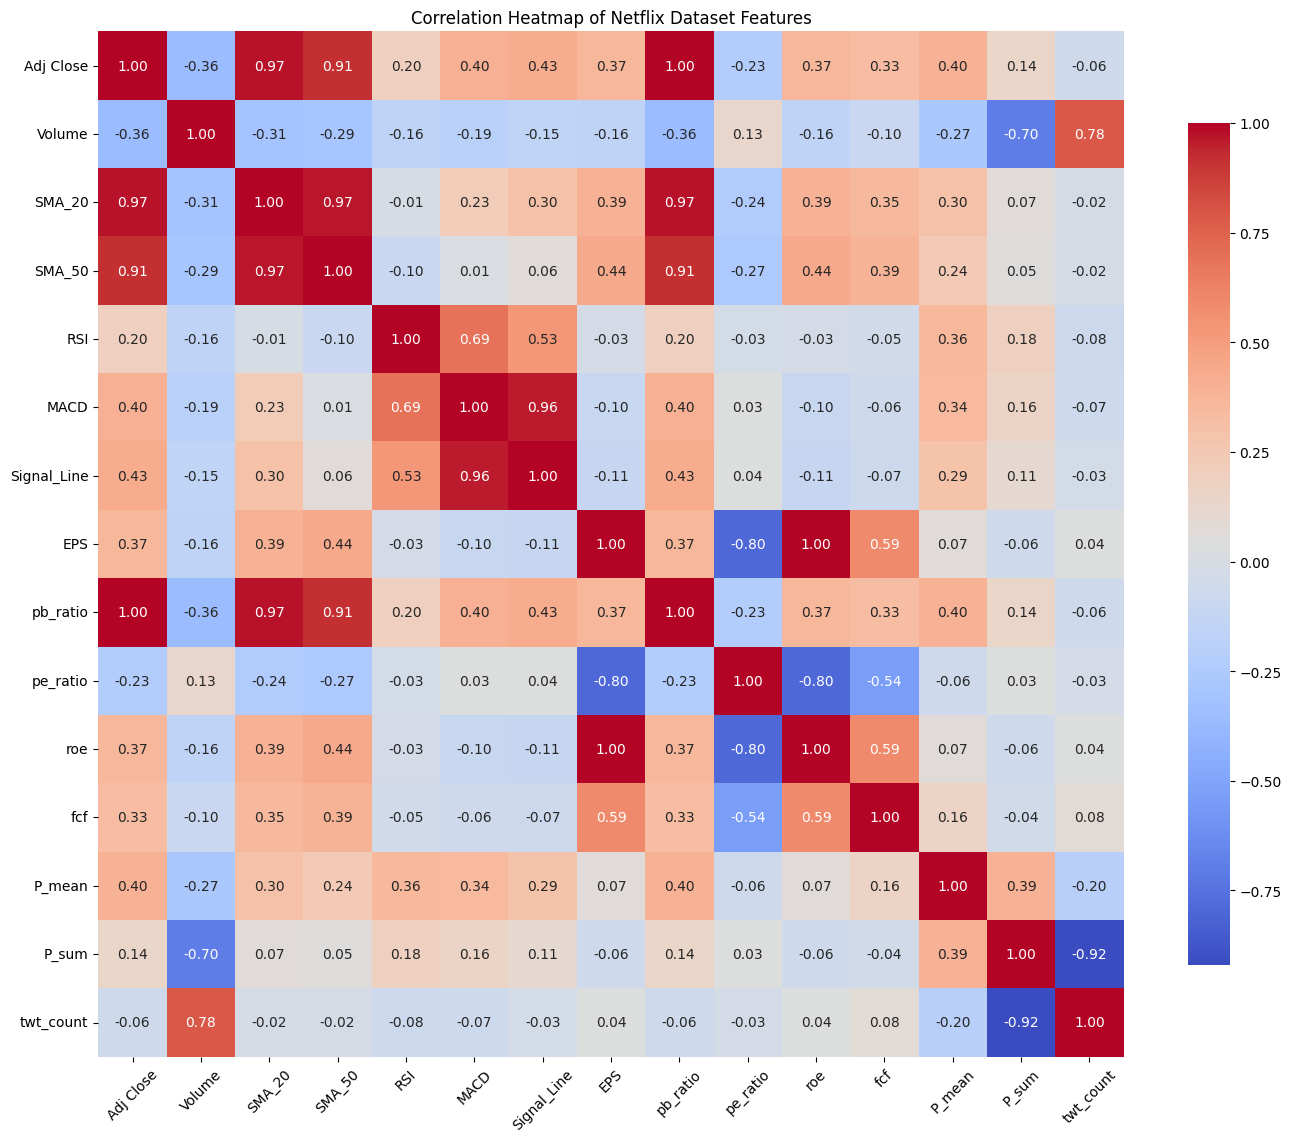

In [22]:
df = pd.read_csv('data/T+F+S_regr.csv')
df = df[['Adj Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'EPS', 'pb_ratio', 'pe_ratio', 'roe', 'fcf', 'P_mean', 'P_sum', 'twt_count']]
# Calculate correlations
corr = df.corr()

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .75})
plt.title("Correlation Heatmap of Netflix Dataset Features")
plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.yticks(rotation=0)  # Ensure y labels are horizontal for better readability
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()


## **Helper Functions:** For Data Preparation, Data Scaling, Visualization, Model Training, and Evaluation

In [34]:
#Transforms time-series dataframe into a format suitable for supervised learning, where each observation consists of a set of features from a rolling window of past values and a corresponding target value.
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window(number of past observations to consider) of Xt-n to predict Xt
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    #Storing features and target values for each rolling window
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    dates = []

    for i in range(len(df) - window): #Iterating through the data 
        
        # Get close, ts_polarity, tw_vol, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1] #data taken from i to i+window
        ts_polarity = df.iloc[i:(i + window), feature_col_number2] #data taken from i to i+window
        tw_vol = df.iloc[i:(i + window), feature_col_number3] #data taken from i to i+window
        target = df.iloc[(i + window), target_col_number] #Target is the value right after the window
        date = df.index[i + window]

        # Append values in the lists
        X_close.append(close)
        X_polarity.append(ts_polarity)
        X_volume.append(tw_vol)
        y.append(target)
        dates.append(date)


    # Features lists are horizontally stacked together to form a single array where each row represents a rolling window of features.  
    # Target list is converted to a single array and reshaped to a single column 
    return np.hstack((X_close,X_polarity,X_volume)), np.array(y).reshape(-1, 1), np.array(dates) #Returning features (X) and target (y) arrays

In [35]:
# Function to scale the data
def data_scale_regr(X_train, X_test, y_train):
    # Use the MinMaxScaler to scale data between 0 and 1.
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    # Fit the scaler for the Training Data
    x_scaler.fit(X_train)
    y_scaler.fit(y_train)

    # Scale both the training and testing data with the fitted scalers
    X_train_scaled = x_scaler.transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    
    return X_train_scaled, X_test_scaled, y_train_scaled, x_scaler, y_scaler

In [12]:
def data_scale_classi(X_train, X_test):
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

In [37]:
def build_lstm_model(input_shape, units, dropout, num_layers):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Define input shape explicitly
    
    # Add the specified number of LSTM layers
    for _ in range(num_layers):
        model.add(LSTM(units=units, return_sequences=True if _ < num_layers - 1 else False))
        model.add(Dropout(dropout))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [38]:
def scale_lstm_data(X, y):
    # Reshape X to 2D for scaling purposes
    n_samples, n_timesteps, n_features = X.shape
    X_2d = X.reshape((n_samples * n_timesteps, n_features))
    
    # Create scaler for X and fit on training data
    scaler_X = MinMaxScaler()
    X_2d_scaled = scaler_X.fit_transform(X_2d)
    
    # Reshape scaled X back to 3D
    X_scaled = X_2d_scaled.reshape((n_samples, n_timesteps, n_features))
    
    # Scale y without reshaping to 2D
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    return X_scaled, y_scaled, scaler_X, scaler_y

In [39]:
def regression_model(df, X, y, model_name, dataset_name, dates):
    
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) #split data into train and test. shuffle=False to keep the order of the data. 
    test_dates = dates[len(dates) - len(y_test_orig):]
    X_train, X_test, y_train, x_scaler, y_scaler = data_scale_regr(X_train_orig, X_test_orig, y_train_orig) #scales the data to a range b/w 0 and 1
    
    if model_name == "rfr":
        print("\n","Random Forest Regressor")
        # Create the Random Forest regressor instance
        model = RandomForestRegressor(n_estimators=1000, max_depth=2, bootstrap=False, min_samples_leaf=1)
        # Fit the model
        model.fit(X_train, y_train.ravel())
        # Make some predictions
        predicted = model.predict(X_test) 
        predicted_prices = y_scaler.inverse_transform(predicted.reshape(-1, 1))

        name = "models\\" + dataset_name + "_model_rfr.joblib"
        joblib.dump(model, name)

    elif model_name == "xgbr":
        print("\n","XG Boost Regressor")
        # Create the XG Boost regressor instance
        model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
        # Fit the model
        model.fit(X_train, y_train.ravel())
        # Make some predictions
        predicted = model.predict(X_test) 
        # Getting original values back
        predicted_prices = y_scaler.inverse_transform(predicted.reshape(-1, 1))

        name = "models\\" + dataset_name + "_model_xgbr.json"
        model.save_model(name)
        
    elif model_name == "lstm":
        print("\n","LSTM_RNN")
        X = X.reshape(X.shape[0], 3, -1)  # Reshape for LSTM

        # Store cv results
        cv_rmse_scores = []
        cv_r2_scores = []

        n_splits = 5 #cv=5 
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        if dataset_name == "ts":
            batch_size = 32
            dropout = 0.2 
            epochs = 100 
            num_layers = 2 
            units = 50
        elif dataset_name == "tf":
            batch_size = 10
            dropout = 0.2 
            epochs = 100 
            num_layers = 5
            units = 15
        elif dataset_name == "fs":
            batch_size = 24
            dropout = 0.2 
            epochs = 200 
            num_layers = 2
            units = 30
            
        for train_index, test_index in kf.split(X):
            # Split the data into training and testing sets
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Scale the data specifically for LSTM
            X_train_scaled, y_train_scaled, scaler_X, scaler_y = scale_lstm_data(X_train, y_train)

            model = build_lstm_model((X_train_scaled.shape[1], X_train_scaled.shape[2]), units, dropout, num_layers)
            early_stopping = EarlyStopping(monitor='val_loss', patience=10) # Stop training when a monitored quantity has stopped improving.
            model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping], validation_split=0.1)

            # Scale the test set X without fitting the scaler again
            n_test_samples, n_timesteps, n_features = X_test.shape
            X_test_2d = X_test.reshape((n_test_samples * n_timesteps, n_features))
            X_test_2d_scaled = scaler_X.transform(X_test_2d)
            X_test_scaled = X_test_2d_scaled.reshape((n_test_samples, n_timesteps, n_features))

            # Predict and inverse transform the predictions
            y_pred_scaled = model.predict(X_test_scaled)
            y_pred = scaler_y.inverse_transform(y_pred_scaled)

            # Calculate and store the RMSE and R-squared for this fold
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            cv_rmse_scores.append(rmse)
            cv_r2_scores.append(r2)

            model.save(f"models\\" + dataset_name + "_model_lstm.keras")

        print("Average CV RMSE for LSTM-RNN:", np.mean(cv_rmse_scores))
        print("Average CV R-squared for LSTM-RNN:", np.mean(cv_r2_scores))

        # Scale the original test set for final evaluation
        X_test_orig_reshaped = X_test_orig.reshape(X_test_orig.shape[0], 3, -1)
        X_test_orig_scaled, _, _, _ = scale_lstm_data(X_test_orig_reshaped, y_test_orig)
        predicted_prices_scaled = model.predict(X_test_orig_scaled)
        predicted_prices = y_scaler.inverse_transform(predicted_prices_scaled)

        # Evaluating the model
        rmse = np.sqrt(mean_squared_error(y_test_orig, predicted_prices))
        r2 = r2_score(y_test_orig, predicted_prices)
        print("Root Mean Squared Error of LSTM-RNN is:", rmse)
        print("R-squared of LSTM-RNN is:", r2)

        # predicted_prices = y_scaler.inverse_transform(model.predict(X_test_orig))

    if model_name != "lstm":
        # Cross-Validation
        rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
        r2_scorer = make_scorer(r2_score)
        cv_rmse_scores = cross_val_score(model, X, y.ravel(), cv=5, scoring=rmse_scorer)
        cv_r2_scores = cross_val_score(model, X, y.ravel(), cv=5, scoring=r2_scorer)
        print("Root Mean Squared Error of", model_name, "is: ", np.sqrt(mean_squared_error(y_test_orig, predicted_prices)))
        print("R-squared of", model_name, "is: ", r2_score(y_test_orig, predicted_prices))
        print("Cross-Validation RMSE: ", -cv_rmse_scores.mean())
        print("Cross-Validation R-squared: ", cv_r2_scores.mean())


    # Create a DataFrame of Real and Predicted values
    stocks = pd.DataFrame({
        "date": test_dates,
        "Real": y_test_orig.ravel(),
        "Predicted": predicted_prices.ravel()
    }) 

    print(stocks)

    # Plot the real vs predicted values as a line chart
    stocks.plot(title = "Real vs Predicted values of NFLX")

    return model, stocks

In [11]:
def classification_model(X, y, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_scaled, X_test_scaled = data_scale_classi(X_train, X_test) 

    if model_name == "rfc":
        print("\n","Random Forest Classifier")

        # Create RFClassifier model
        model = RandomForestClassifier(n_estimators=500, random_state=78)

        # Fit the model
        model = model.fit(X_train_scaled, y_train.ravel()) 

    elif model_name == "gbc":
        print("\n","Gradient Boosting Classifier")
        
        # Creating GradientBoostingClassifier model
        model = GradientBoostingClassifier(n_estimators=20,
                                                learning_rate=0.75,
                                                max_features=5,
                                                max_depth=3,
                                                random_state=0)
        # Fitting the model
        model.fit(X_train_scaled, y_train.ravel())    


    # Scoring the model
    print("Accuracy score (training): {0:.3f}".format(
        model.score(
            X_train_scaled, 
            y_train)))

    # Cross-validation accuracy
    cv_scores = cross_val_score(model, X_train_scaled, y_train.ravel(), cv=10)
    print("Mean cross-validation accuracy:", cv_scores.mean())

    # Making predictions
    predictions = model.predict(X_test_scaled)
    pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(20)

    # Generating accuracy score for predictions using y_test
    acc_score = accuracy_score(y_test, predictions)
    print(f"Accuracy Score : {acc_score}")

    # Generating the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"]
    )

    # Displaying results
    display(cm_df)

    # Generating classification report
    print("Classification Report")
    print(classification_report(y_test, predictions))

In [25]:
def calculate_directional_accuracy(df_pred_acc):
    
    # Calculate the change in real and predicted prices
    df_pred_acc['Real_Change'] = df_pred_acc['Real'].diff()
    df_pred_acc['Predicted_Change'] = df_pred_acc['Predicted'].diff()
    
    # Define the accuracy of directional prediction
    df_pred_acc['Accuracy'] = ((df_pred_acc['Real_Change'] > 0) & (df_pred_acc['Predicted_Change'] > 0)) | \
                              ((df_pred_acc['Real_Change'] < 0) & (df_pred_acc['Predicted_Change'] < 0))
    df_pred_acc['Accuracy'] = df_pred_acc['Accuracy'].astype(int)
    
    # Handle NaN values from diff() for the first row
    df_pred_acc.loc[0, 'Accuracy'] = np.nan 
    
    # Drop the change columns
    df_pred_acc.drop(['Real_Change', 'Predicted_Change'], axis=1, inplace=True)
    
    # Calculate the percentage of accurate predictions
    percentage_ones = (df_pred_acc['Accuracy'].sum() / df_pred_acc['Accuracy'].count()) * 100
    
    # Print and return results
    print(f"Percentage of correct directional predictions: {percentage_ones:.2f}%")
    
    return df_pred_acc

## **Regression Problem**

### **Technical + Sentimental Features**

#### **Initial Data Analysis**

In [41]:
df_ts_regr = pd.read_csv('data/T+S_regr.csv')
df_ts_regr = df_ts_regr[['Adj Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'P_mean', 'P_sum', 'twt_count', 'NFLX_Returns']]
print(df_ts_regr)

      Adj Close    Volume   SMA_20   SMA_50     RSI   MACD  Signal_Line  \
0        344.72  10049100  323.828  314.270  80.623  5.605        4.410   
1        349.29  14758600  325.594  314.825  79.142  6.789        4.886   
2        351.29   7817400  327.570  315.429  77.248  7.799        5.468   
3        349.73   9717900  329.434  316.054  74.370  8.376        6.050   
4        353.54   5685500  331.446  316.856  74.587  9.038        6.647   
...         ...       ...      ...      ...     ...    ...          ...   
1034     179.95   5194700  183.188  187.953  48.188 -5.970       -7.471   
1035     185.88   7334300  182.532  187.306  60.769 -5.120       -7.001   
1036     184.06   5753400  181.878  186.677  61.037 -4.541       -6.509   
1037     189.27   6334500  181.412  186.264  56.787 -3.619       -5.931   
1038     186.98   5831300  180.619  186.036  60.816 -3.039       -5.353   

      P_mean  P_sum  twt_count  NFLX_Returns  
0     0.0366     25        683      0.039503  
1    

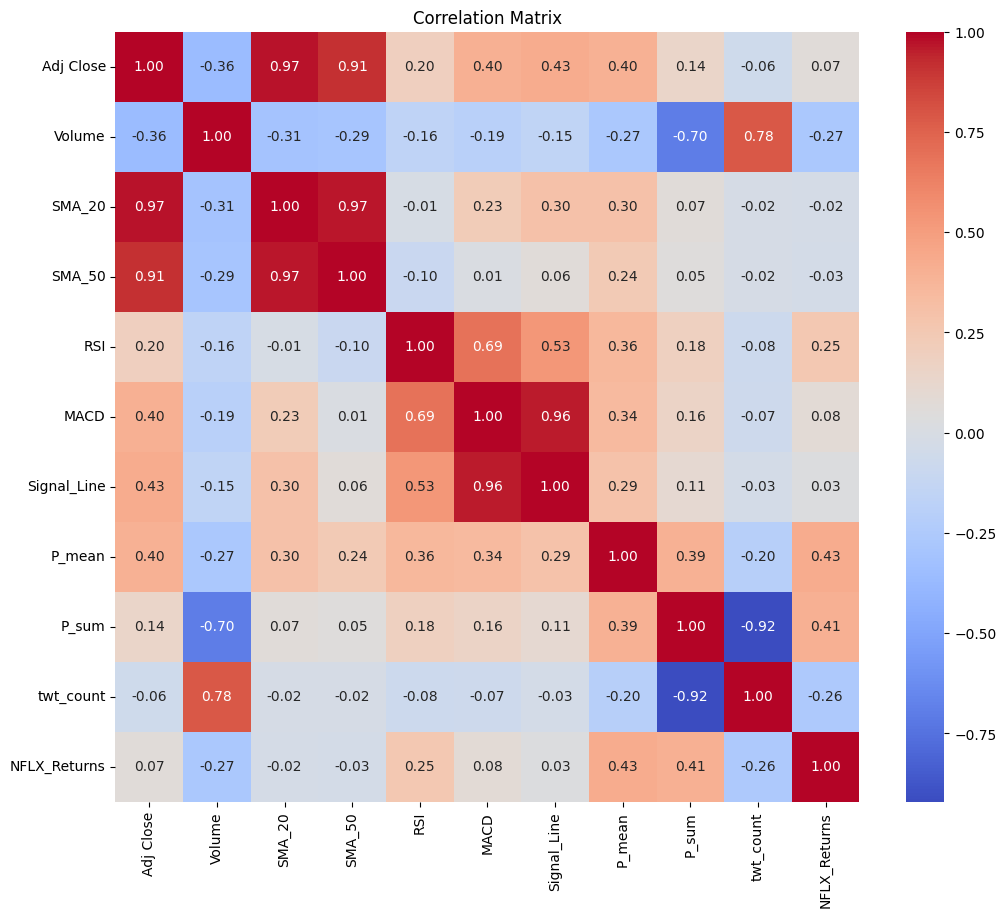

In [42]:
corr_matrix = df_ts_regr.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [43]:
# Print the correlation values with the target variable
print("Correlation with Adj_Close:")
print(corr_matrix['Adj Close'].sort_values(ascending=False))

Correlation with Adj_Close:
Adj Close       1.000000
SMA_20          0.970566
SMA_50          0.914698
Signal_Line     0.426736
MACD            0.401138
P_mean          0.398083
RSI             0.197035
P_sum           0.143056
NFLX_Returns    0.067834
twt_count      -0.061797
Volume         -0.364994
Name: Adj Close, dtype: float64


**Distribution of Sentiment scores:**

In [4]:
import plotly.express as px

df_ts_regr = pd.read_csv('data/T+S_regr.csv')

# Histogram for Mean Sentiment Scores
fig_mean = px.histogram(df_ts_regr, x="P_mean", nbins=50, title='Distribution of Mean Sentiment Scores')
fig_mean.show()

# Histogram for Summed Sentiment Scores
fig_sum = px.histogram(df_ts_regr, x="P_sum", nbins=50, title='Distribution of Summed Sentiment Scores')
fig_sum.show()

#### **Hyperparameter Tuning - Finding Best Features for the models**

Running the models on the features with the highest correlation did not result in the best stock prediction models. Hence, the best features were found by training models with different combinations of features to find out which gives the best results.

**XG Boost Regressor** - To Select the best features we make use of XGBoost Regressor simply because rfr was unable to capture the patterns and relationships in the data and LSTM would require tuning the hyperparameters whilst finding the best features which is computationally super-heavy.

In [52]:
df_ts_regr = pd.read_csv('data/T+S_regr.csv')
best_score = float('-inf')
best_combination = None
window_size = 3

# Define lists of features
list1 = ['Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'NFLX_Returns']
list2 = ['P_mean', 'P_sum', 'twt_count']

# Generate all combinations: one from list1 and one from list2
feature_combinations = list(itertools.product(list1, list2))

for comb in feature_combinations:
    selected_features = ['Adj Close'] + list(comb)
    df_pred_xgbr = df_ts_regr[['date'] + selected_features]
    df_pred_xgbr.set_index('date', inplace=True)

    X, y, dates = window_data(df_pred_xgbr, window_size, 0, 1, 2, 0) 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    model_xgbr, pred_xgbr = regression_model(df_pred_xgbr, X, y, "xgbr", "ts", dates)
    model_xgbr.fit(X_train, y_train)

    # Calculate CV RMSE and CV R2
    rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
    r2_scorer = make_scorer(r2_score)
    
    cv_rmse_scores = cross_val_score(model_xgbr, X, y.ravel(), cv=5, scoring=rmse_scorer)
    cv_r2_scores = cross_val_score(model_xgbr, X, y.ravel(), cv=5, scoring=r2_scorer)
    
    cv_rmse = -cv_rmse_scores.mean() 
    cv_r2 = cv_r2_scores.mean()
    
    score = cv_r2  - 0.1 * cv_rmse
    
    if score > best_score:
        best_score = score
        best_combination = selected_features
        
    print(f"Combination: {selected_features} with score: {score}")

print(f"Best combination of features: {best_combination} with score: {best_score} for XG Boost Regressor")



 XG Boost Regressor
Combination: ['Adj Close', 'Volume', 'P_mean'] with score: -1.3704610257682484

 XG Boost Regressor
Combination: ['Adj Close', 'Volume', 'P_sum'] with score: -1.3156603555449196

 XG Boost Regressor
Combination: ['Adj Close', 'Volume', 'twt_count'] with score: -1.4919814265704667

 XG Boost Regressor
Combination: ['Adj Close', 'SMA_20', 'P_mean'] with score: -1.6430948502267115

 XG Boost Regressor
Combination: ['Adj Close', 'SMA_20', 'P_sum'] with score: -1.4269329730566325

 XG Boost Regressor
Combination: ['Adj Close', 'SMA_20', 'twt_count'] with score: -1.6097493618709424

 XG Boost Regressor
Combination: ['Adj Close', 'SMA_50', 'P_mean'] with score: -1.5059142395439404

 XG Boost Regressor
Combination: ['Adj Close', 'SMA_50', 'P_sum'] with score: -1.3700879795886904

 XG Boost Regressor
Combination: ['Adj Close', 'SMA_50', 'twt_count'] with score: -1.516601962714381

 XG Boost Regressor
Combination: ['Adj Close', 'RSI', 'P_mean'] with score: -1.597058603082965

**Hyperparameter Tuning - LSTM**

In [94]:
# Load your data
df_fs = pd.read_csv('data/T+S_regr.csv')
df_fs = df_fs[['date', 'Adj Close', 'SMA_20', 'P_sum']]
df_fs.set_index('date', inplace=True)

param_grid = {
    'units': [30, 50, 100, 150, 200],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'epochs': [100, 150, 200],
    'window_sizes': [3, 4, 5],
    'num_layers': [2, 3, 4],
    'batch_sizes': [20, 24, 32] 
}

best_accuracy = 0
best_params = {}

for window_size in param_grid['window_sizes']:
    X_fs, y_fs, dates = window_data(df_fs, window_size, 0, 1, 2, 0)
    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X_fs, y_fs, dates, test_size=0.2, random_state=42, shuffle=False)
    X_train = X_train.reshape((X_train.shape[0], window_size, -1))
    X_test = X_test.reshape((X_test.shape[0], window_size, -1))
    X_train_scaled, y_train_scaled, scaler_X, scaler_y = scale_lstm_data(X_train, y_train)

    for units in param_grid['units']:
        for dropout in param_grid['dropout']:
            for epochs in param_grid['epochs']:
                for num_layers in param_grid['num_layers']:
                    for batch_size in param_grid['batch_sizes']:
                        print(f"Testing with parameters: units={units}, dropout={dropout}, epochs={epochs}, window_size={window_size}, num_layers={num_layers}, batch_size={batch_size}")
                        
                        model = build_lstm_model((X_train_scaled.shape[1], X_train_scaled.shape[2]), units, dropout, num_layers)
                        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
                        model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping], validation_split=0.1)

                        # Evaluate the model
                        X_test_scaled = scaler_X.transform(X_test.reshape(X_test.shape[0] * window_size, -1)).reshape(X_test.shape)
                        y_pred_scaled = model.predict(X_test_scaled)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled)

                        df_pred = pd.DataFrame({
                            'Date': dates_test,
                            'Real': y_test.flatten(),
                            'Predicted': y_pred.flatten()
                        })
                        
                        df_pred['Real_Change'] = df_pred['Real'].diff()
                        df_pred['Predicted_Change'] = df_pred['Predicted'].diff()
                        df_pred['Accuracy'] = ((df_pred['Real_Change'] > 0) & (df_pred['Predicted_Change'] > 0)) | ((df_pred['Real_Change'] < 0) & (df_pred['Predicted_Change'] < 0))
                        df_pred['Accuracy'] = df_pred['Accuracy'].astype(int)
                        df_pred.loc[df_pred.index[0], 'Accuracy'] = np.nan

                        accuracy = df_pred['Accuracy'].sum() / df_pred['Accuracy'].count() * 100
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_params = {'units': units, 'dropout': dropout, 'epochs': epochs, 'window_size': window_size, 'num_layers': num_layers, 'batch_size': batch_size}
                            
                            df_pred.drop(['Real_Change', 'Predicted_Change'], axis=1, inplace=True)
                            df_pred.rename(columns={'Date': 'date'}, inplace=True)
                            df_pred.to_csv('data/predictions/ts_pred_lstm1.csv', index=False)

                        print(f"Current Accuracy: {accuracy:.2f}%")

                print(f"Until Now: Best Parameters: {best_params}, Best Accuracy: {best_accuracy:.2f}%")

print(f"Final Best Parameters: {best_params}, Final Best Accuracy: {best_accuracy:.2f}%")

Testing with parameters: units=50, dropout=0.3, epochs=50, window_size=4, num_layers=3, batch_size=20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Current Accuracy: 53.40%
Testing with parameters: units=50, dropout=0.3, epochs=50, window_size=4, num_layers=3, batch_size=24
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Current Accuracy: 53.40%
Until Now: Best Parameters: {'units': 50, 'dropout': 0.3, 'epochs': 50, 'window_size': 4, 'num_layers': 3, 'batch_size': 20}, Best Accuracy: 53.40%
Testing with parameters: units=50, dropout=0.3, epochs=100, window_size=4, num_layers=3, batch_size=20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Current Accuracy: 50.49%
Testing with parameters: units=50, dropout=0.3, epochs=100, window_size=4, num_layers=3, batch_size=24
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Current Accuracy: 55.34%
Until Now: Best Parameters: {'units': 50, 'dropout': 0.3, 'epochs': 100, 'window_size': 4, 'num_layers': 3, 'batch_size': 24}, Best Accuracy: 55.34%
Testing with parameters: units=100, dropo

#### **Executing the predictive models (after hyperparameter tuning) and obtaining their performance outcomes** 

In [27]:
df_regr = pd.read_csv('data/T+S_regr.csv')
df_rfr_ts = df_regr[['date', 'Adj Close', 'SMA_20', 'P_sum']]
df_rfr_ts.set_index('date', inplace=True)

# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

# Column index 0 is the `Adj Close` column
# Column index 1 is the `ts_polarity` column
# Column index 2 is the `twitter_volume` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X_rfr_ts, y_rfr_ts, dates = window_data(df_rfr_ts, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

**Random Forest Regressor**


 Random Forest Regressor
Root Mean Squared Error of rfr is:  86.96802592714178
R-squared of rfr is:  0.7691689970573973
Cross-Validation RMSE:  49.75236795656914
Cross-Validation R-squared:  0.017296649907388682
           date    Real   Predicted
0    2021-09-10  598.72  529.278808
1    2021-09-13  589.29  529.278808
2    2021-09-14  577.76  529.278808
3    2021-09-15  582.87  529.278808
4    2021-09-16  586.50  529.278808
..          ...     ...         ...
203  2022-07-01  179.95  292.966607
204  2022-07-05  185.88  292.966607
205  2022-07-06  184.06  292.966607
206  2022-07-07  189.27  292.966607
207  2022-07-08  186.98  292.966607

[208 rows x 3 columns]


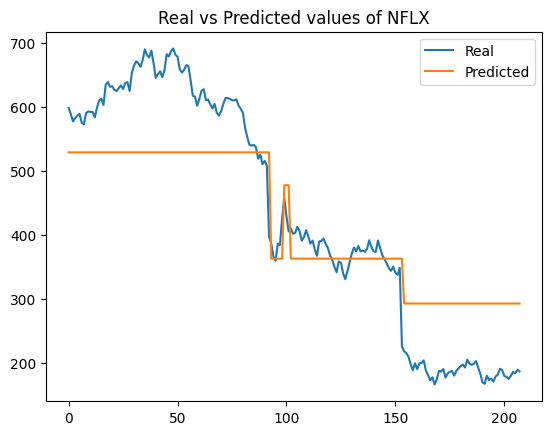

In [28]:
model_rfr_ts, pred_rfr_ts = regression_model(df_rfr_ts, X_rfr_ts, y_rfr_ts, "rfr", "ts", dates)

**XG Boost Regressor**


 XG Boost Regressor
Root Mean Squared Error of xgbr is:  50.75954532029071
R-squared of xgbr is:  0.9213660013690396
Cross-Validation RMSE:  21.331915112548966
Cross-Validation R-squared:  0.873465514237165
           date    Real   Predicted
0    2021-09-10  598.72  584.496887
1    2021-09-13  589.29  590.507446
2    2021-09-14  577.76  585.062256
3    2021-09-15  582.87  581.204346
4    2021-09-16  586.50  581.734497
..          ...     ...         ...
203  2022-07-01  179.95  270.407349
204  2022-07-05  185.88  262.151276
205  2022-07-06  184.06  261.644196
206  2022-07-07  189.27  260.097015
207  2022-07-08  186.98  263.801453

[208 rows x 3 columns]


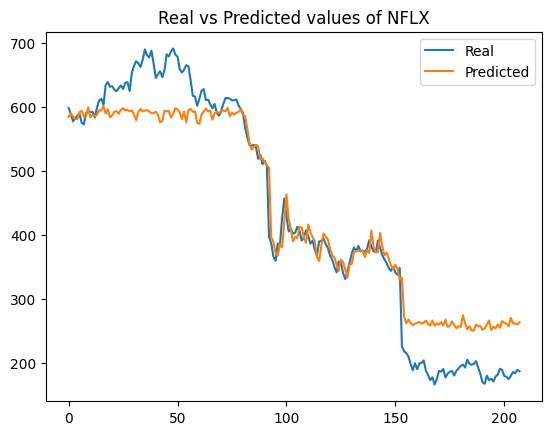

In [26]:
model_xgbr_ts, pred_xgbr_ts = regression_model(df_rfr_ts, X_rfr_ts, y_rfr_ts, "xgbr", "ts", dates)

**LSTM - RNN**


 LSTM_RNN
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Average CV RMSE for LSTM-RNN: 31.52776588076078
Average CV R-squared for LSTM-RNN: 0.9227252828192896
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Root Mean Squared Error of LSTM-RNN is: 67.0675138637721
R-squared of LSTM-RNN is: 0.8627225101032798
           date    Real   Predicted
0    2021-09-10  598.72  556.018066
1    2021-09-13  589.29  556.016418
2    2021-09-14  577.76  551.781982
3    2021-09-15  582.87  548.147217
4    2021-09-16  586.50  549.264160
..          ...     ...         ...
203  2022-07-01  179.95  294.958008
204  2022-07-05  185.88  295.851898
205  2022-07-06  184.06  296.858551
206  2022-07-07  189.27  297.463531
207  2022-07-08  186.98  298.728241

[208 rows x 3 columns]


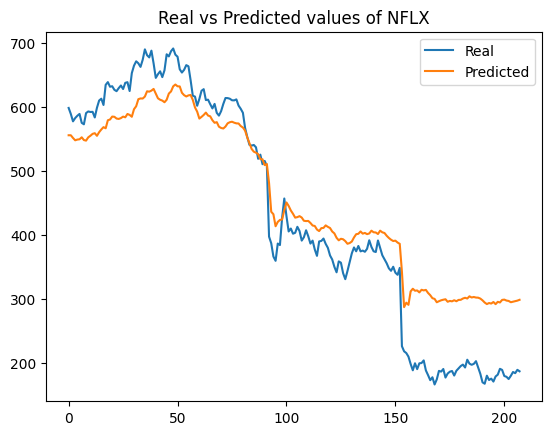

In [146]:
model_lstm_ts, pred_lstm_ts = regression_model(df_rfr_ts, X_rfr_ts, y_rfr_ts, "lstm", "ts", dates)

#### **Calculating Directional Accuracy of Predictions**

In [29]:
results_rfr = calculate_directional_accuracy(pred_rfr_ts)
results_xgbr = calculate_directional_accuracy(pred_xgbr_ts)
results_lstm = calculate_directional_accuracy(pred_lstm_ts)

# Save each DataFrame to the respective CSV file
results_rfr.to_csv("data/predictions/ts_pred_rfr.csv", index=False)
results_xgbr.to_csv("data/predictions/ts_pred_xgbr.csv", index=False)
results_lstm.to_csv("data/predictions/ts_pred_lstm.csv", index=False)

Percentage of correct directional predictions: 1.45%


### **Technical + Fundamental Features**

#### **Initial Data Analysis**

In [178]:
df_tf_regr = pd.read_csv('data/T+F_regr.csv')
df_tf_regr = df_tf_regr[['Adj Close', 'Volume','SMA_20','SMA_50','RSI','MACD','Signal_Line' ,'EPS', 'pe_ratio', 'pb_ratio', 'roe', 'fcf', 'NFLX_Returns']]
print(df_tf_regr)

      Adj Close    Volume   SMA_20   SMA_50     RSI   MACD  Signal_Line   EPS  \
0        344.72  10049100  323.828  314.270  80.623  5.605        4.410  0.64   
1        349.29  14758600  325.594  314.825  79.142  6.789        4.886  0.64   
2        351.29   7817400  327.570  315.429  77.248  7.799        5.468  0.64   
3        349.73   9717900  329.434  316.054  74.370  8.376        6.050  0.64   
4        353.54   5685500  331.446  316.856  74.587  9.038        6.647  0.64   
...         ...       ...      ...      ...     ...    ...          ...   ...   
1034     179.95   5194700  183.188  187.953  48.188 -5.970       -7.471  3.20   
1035     185.88   7334300  182.532  187.306  60.769 -5.120       -7.001  3.20   
1036     184.06   5753400  181.878  186.677  61.037 -4.541       -6.509  3.20   
1037     189.27   6334500  181.412  186.264  56.787 -3.619       -5.931  3.20   
1038     186.98   5831300  180.619  186.036  60.816 -3.039       -5.353  3.20   

      pe_ratio  pb_ratio   

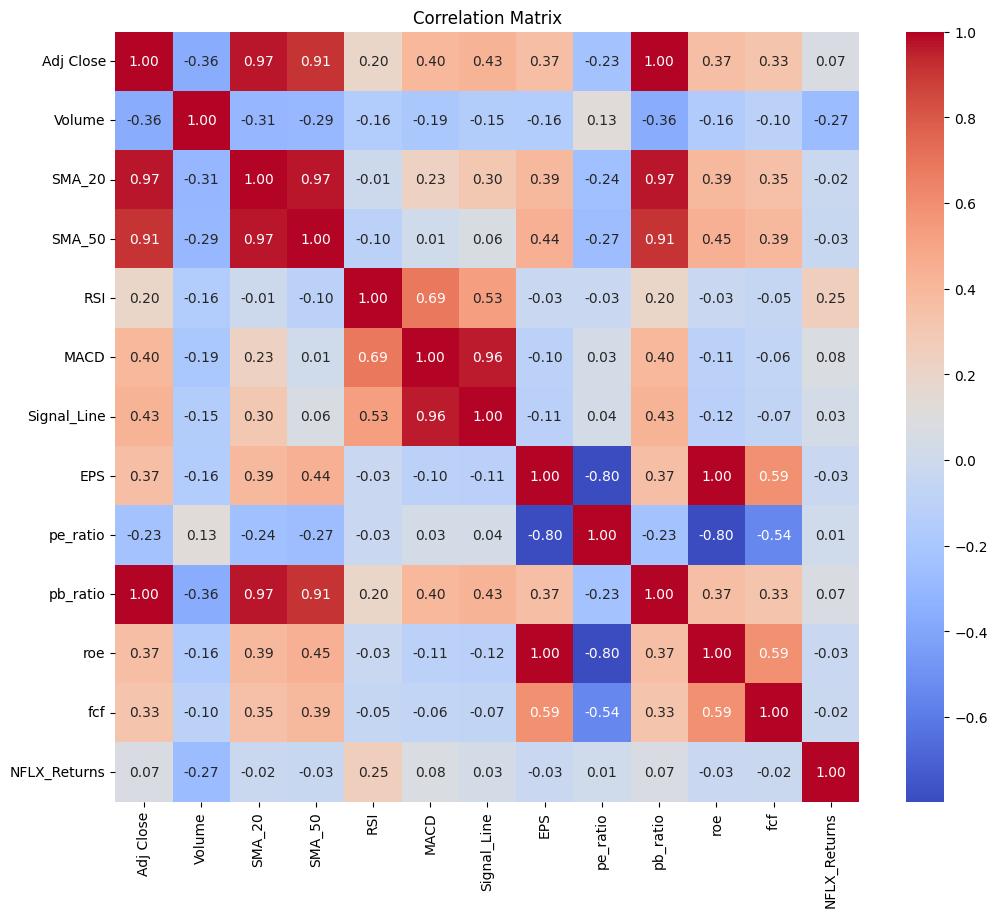

In [179]:
corr_matrix = df_tf_regr.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [180]:
# Print the correlation values with the target variable
print("Correlation with Adj_Close:")
print(corr_matrix['Adj Close'].sort_values(ascending=False))

Correlation with Adj_Close:
Adj Close       1.000000
pb_ratio        0.999979
SMA_20          0.970566
SMA_50          0.914698
Signal_Line     0.426736
MACD            0.401138
EPS             0.367123
roe             0.366499
fcf             0.332626
RSI             0.197035
NFLX_Returns    0.067834
pe_ratio       -0.231390
Volume         -0.364994
Name: Adj Close, dtype: float64


**Overall Trends and Patterns of each Fundamental Features**

In [6]:
df_tf_regr = pd.read_csv('data/T+F_regr.csv')

fig = make_subplots(rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.02, subplot_titles=('EPS', 'PE Ratio', 'PB Ratio', 'ROE', 'FCF'))

# EPS
fig.add_trace(go.Scatter(x=df_tf_regr['date'], y=df_tf_regr['EPS'], name='EPS'), row=1, col=1)

# PE Ratio
fig.add_trace(go.Scatter(x=df_tf_regr['date'], y=df_tf_regr['pe_ratio'], name='PE Ratio'), row=2, col=1)

# PB Ratio
fig.add_trace(go.Scatter(x=df_tf_regr['date'], y=df_tf_regr['pb_ratio'], name='PB Ratio'), row=3, col=1)

# ROE
fig.add_trace(go.Scatter(x=df_tf_regr['date'], y=df_tf_regr['roe'], name='ROE'), row=4, col=1)

# FCF
fig.add_trace(go.Scatter(x=df_tf_regr['date'], y=df_tf_regr['fcf'], name='FCF'), row=5, col=1)

fig.update_layout(height=1200, title_text="Fundamental Analysis Over Time")
fig.show()


#### **Hyperparameter Tuning - Finding Best Features for the models**

**XG Boost Regressor** - To Select the best features we make use of XGBoost Regressor simply because rfr was unable to capture the patterns and relationships in the data and LSTM would require tuning the hyperparameters whilst finding the best features which is computationally super-heavy.

In [51]:
df_tf_regr = pd.read_csv('data/T+F_regr.csv')
best_score = float('-inf')
best_combination = None
window_size = 3

# Define lists of features
list1 = ['Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'NFLX_Returns']
list2 = ['EPS', 'pe_ratio', 'pb_ratio', 'roe', 'fcf']

# Generate all combinations: one from list1 and one from list2
feature_combinations = list(itertools.product(list1, list2))

for comb in feature_combinations:
    selected_features = ['Adj Close'] + list(comb)
    df_pred_xgbr = df_tf_regr[['date'] + selected_features]
    df_pred_xgbr.set_index('date', inplace=True)

    X, y, dates = window_data(df_pred_xgbr, window_size, 0, 1, 2, 0) 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    model_xgbr, pred_xgbr = regression_model(df_pred_xgbr, X, y, "xgbr", "ts", dates)
    model_xgbr.fit(X_train, y_train)

    # Calculate CV RMSE and CV R2
    rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
    r2_scorer = make_scorer(r2_score)
    
    cv_rmse_scores = cross_val_score(model_xgbr, X, y.ravel(), cv=5, scoring=rmse_scorer)
    cv_r2_scores = cross_val_score(model_xgbr, X, y.ravel(), cv=5, scoring=r2_scorer)
    
    cv_rmse = -cv_rmse_scores.mean() 
    cv_r2 = cv_r2_scores.mean()
    
    score = cv_r2  - 0.1 * cv_rmse
    
    if score > best_score:
        best_score = score
        best_combination = selected_features
        
    print(f"Combination: {selected_features} with score: {score}")

print(f"Best combination of features: {best_combination} with score: {best_score} for XG Boost Regressor")


 XG Boost Regressor
Combination: ['Adj Close', 'Volume', 'EPS'] with score: -2.0187337875505165

 XG Boost Regressor
Combination: ['Adj Close', 'Volume', 'pe_ratio'] with score: -1.4520887332636527

 XG Boost Regressor
Combination: ['Adj Close', 'Volume', 'pb_ratio'] with score: -1.4203282347346229

 XG Boost Regressor
Combination: ['Adj Close', 'Volume', 'roe'] with score: -1.9036600501312455

 XG Boost Regressor
Combination: ['Adj Close', 'Volume', 'fcf'] with score: -1.8069848158352122

 XG Boost Regressor
Combination: ['Adj Close', 'SMA_20', 'EPS'] with score: -2.536023716244465

 XG Boost Regressor
Combination: ['Adj Close', 'SMA_20', 'pe_ratio'] with score: -1.936213831895958

 XG Boost Regressor
Combination: ['Adj Close', 'SMA_20', 'pb_ratio'] with score: -2.2622403930249897

 XG Boost Regressor
Combination: ['Adj Close', 'SMA_20', 'roe'] with score: -2.4846831823525015

 XG Boost Regressor
Combination: ['Adj Close', 'SMA_20', 'fcf'] with score: -2.3665833281800595

 XG Boost R

**Hyperparameter Tuning - LSTM**

In [ ]:
# Load your data
df_tf = pd.read_csv('data/T+F_regr.csv')
df_tf = df_tf[['date', 'Adj Close', 'pb_ratio', 'Signal_Line']]
df_tf.set_index('date', inplace=True)

param_grid = {
    'units': [30, 50, 100, 150, 200],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'epochs': [100, 150, 200],
    'window_sizes': [3, 4, 5],
    'num_layers': [2, 3, 4],
    'batch_sizes': [20, 24, 32] 
}

best_accuracy = 0
best_params = {}

for window_size in param_grid['window_sizes']:
    X_tf, y_tf, dates = window_data(df_tf, window_size, 0, 1, 2, 0)
    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X_tf, y_tf, dates, test_size=0.2, random_state=42, shuffle=False)
    X_train = X_train.reshape((X_train.shape[0], window_size, -1))
    X_test = X_test.reshape((X_test.shape[0], window_size, -1))
    X_train_scaled, y_train_scaled, scaler_X, scaler_y = scale_lstm_data(X_train, y_train)

    for units in param_grid['units']:
        for dropout in param_grid['dropout']:
            for epochs in param_grid['epochs']:
                for num_layers in param_grid['num_layers']:
                    for batch_size in param_grid['batch_sizes']:
                        print(f"Testing with parameters: units={units}, dropout={dropout}, epochs={epochs}, window_size={window_size}, num_layers={num_layers}, batch_size={batch_size}")
                        
                        model = build_lstm_model((X_train_scaled.shape[1], X_train_scaled.shape[2]), units, dropout, num_layers)
                        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
                        model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping], validation_split=0.1)

                        # Evaluate the model
                        X_test_scaled = scaler_X.transform(X_test.reshape(X_test.shape[0] * window_size, -1)).reshape(X_test.shape)
                        y_pred_scaled = model.predict(X_test_scaled)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled)

                        df_pred = pd.DataFrame({
                            'Date': dates_test,
                            'Real': y_test.flatten(),
                            'Predicted': y_pred.flatten()
                        })
                        
                        df_pred['Real_Change'] = df_pred['Real'].diff()
                        df_pred['Predicted_Change'] = df_pred['Predicted'].diff()
                        df_pred['Accuracy'] = ((df_pred['Real_Change'] > 0) & (df_pred['Predicted_Change'] > 0)) | ((df_pred['Real_Change'] < 0) & (df_pred['Predicted_Change'] < 0))
                        df_pred['Accuracy'] = df_pred['Accuracy'].astype(int)
                        df_pred.loc[df_pred.index[0], 'Accuracy'] = np.nan

                        accuracy = df_pred['Accuracy'].sum() / df_pred['Accuracy'].count() * 100
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_params = {'units': units, 'dropout': dropout, 'epochs': epochs, 'window_size': window_size, 'num_layers': num_layers, 'batch_size': batch_size}
                            
                            df_pred.drop(['Real_Change', 'Predicted_Change'], axis=1, inplace=True)
                            df_pred.rename(columns={'Date': 'date'}, inplace=True)
                            df_pred.to_csv('data/predictions/ts_pred_lstm1.csv', index=False)

                        print(f"Current Accuracy: {accuracy:.2f}%")

                print(f"Until Now: Best Parameters: {best_params}, Best Accuracy: {best_accuracy:.2f}%")

print(f"Final Best Parameters: {best_params}, Final Best Accuracy: {best_accuracy:.2f}%")

Testing with parameters: units=50, dropout=0.3, epochs=50, window_size=4, num_layers=3, batch_size=20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Current Accuracy: 53.40%
Testing with parameters: units=50, dropout=0.3, epochs=50, window_size=4, num_layers=3, batch_size=24
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Current Accuracy: 53.40%
Until Now: Best Parameters: {'units': 50, 'dropout': 0.3, 'epochs': 50, 'window_size': 4, 'num_layers': 3, 'batch_size': 20}, Best Accuracy: 53.40%
Testing with parameters: units=50, dropout=0.3, epochs=100, window_size=4, num_layers=3, batch_size=20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Current Accuracy: 50.49%
Testing with parameters: units=50, dropout=0.3, epochs=100, window_size=4, num_layers=3, batch_size=24
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Current Accuracy: 55.34%
Until Now: Best Parameters: {'units': 50, 'dropout': 0.3, 'epochs': 100, 'window_size': 4, 'num_layers': 3, 'batch_size': 24}, Best Accuracy: 55.34%
Testing with parameters: units=100, dropo

#### **Executing the predictive models (after hyperparameter tuning) and obtaining their performance outcomes** 

In [44]:
df_rfr_tf = pd.read_csv('data/T+F_regr.csv')
df_rfr_tf = df_rfr_tf[['date', 'Adj Close', 'pb_ratio', 'Signal_Line']]
df_rfr_tf.set_index('date', inplace=True)

# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

# Column index 0 is the `Adj Close` column
# Column index 1 is the `ts_polarity` column
# Column index 2 is the `twitter_volume` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X_rfr_tf, y_rfr_tf, dates = window_data(df_rfr_tf, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

**Random Forest Regressor**


 Random Forest Regressor
Root Mean Squared Error of rfr is:  86.96802592714178
R-squared of rfr is:  0.7691689970573973
Cross-Validation RMSE:  49.75236795656914
Cross-Validation R-squared:  0.01729664990738904
           date    Real   Predicted
0    2021-09-10  598.72  529.278808
1    2021-09-13  589.29  529.278808
2    2021-09-14  577.76  529.278808
3    2021-09-15  582.87  529.278808
4    2021-09-16  586.50  529.278808
..          ...     ...         ...
203  2022-07-01  179.95  292.966607
204  2022-07-05  185.88  292.966607
205  2022-07-06  184.06  292.966607
206  2022-07-07  189.27  292.966607
207  2022-07-08  186.98  292.966607

[208 rows x 3 columns]


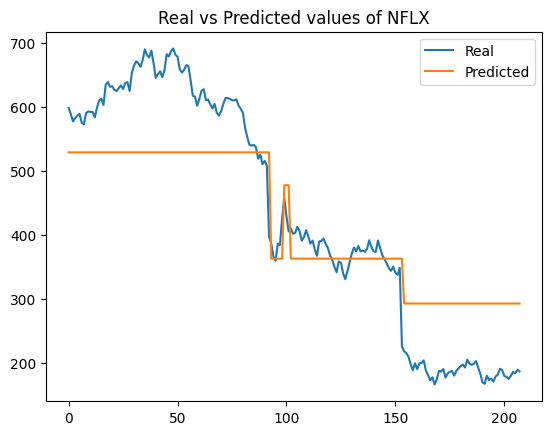

In [45]:
model_rfr_tf, pred_rfr_tf = regression_model(df_rfr_tf, X_rfr_tf, y_rfr_tf, "rfr", "tf", dates)

**XG Boost Regressor**


 XG Boost Regressor
Root Mean Squared Error of xgbr is:  53.47116139881414
R-squared of xgbr is:  0.9127402130337122
Cross-Validation RMSE:  22.947788793904472
Cross-Validation R-squared:  0.8445822692153391
           date    Real   Predicted
0    2021-09-10  598.72  599.883667
1    2021-09-13  589.29  599.243530
2    2021-09-14  577.76  600.519836
3    2021-09-15  582.87  594.552246
4    2021-09-16  586.50  593.873596
..          ...     ...         ...
203  2022-07-01  179.95  261.053345
204  2022-07-05  185.88  260.275604
205  2022-07-06  184.06  258.497589
206  2022-07-07  189.27  258.916992
207  2022-07-08  186.98  259.131073

[208 rows x 3 columns]


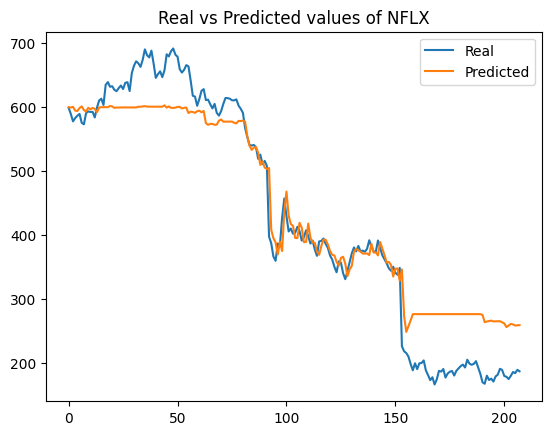

In [259]:
model_xgbr_tf, pred_xgbr_tf = regression_model(df_rfr_tf, X_rfr_tf, y_rfr_tf, "xgbr", "tf", dates)

**LSTM**


 LSTM_RNN


c:\Users\Devesh Pansare\miniconda3\envs\py312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


c:\Users\Devesh Pansare\miniconda3\envs\py312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


c:\Users\Devesh Pansare\miniconda3\envs\py312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


c:\Users\Devesh Pansare\miniconda3\envs\py312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


c:\Users\Devesh Pansare\miniconda3\envs\py312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Average CV RMSE for LSTM-RNN: 14.870646334338883
Average CV R-squared for LSTM-RNN: 0.982223696269183
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Root Mean Squared Error of LSTM-RNN is: 58.688069989782875
R-squared of LSTM-RNN is: 0.8948826099483156
           date    Real   Predicted
0    2021-09-10  598.72  540.503174
1    2021-09-13  589.29  539.438049
2    2021-09-14  577.76  535.345154
3    2021-09-15  582.87  529.992981
4    2021-09-16  586.50  528.291260
..          ...     ...         ...
203  2022-07-01  179.95  244.401367
204  2022-07-05  185.88  245.341629
205  2022-07-06  184.06  247.703094
206  2022-07-07  189.27  249.045197
207  2022-07-08  186.98  251.560654

[208 rows x 3 columns]


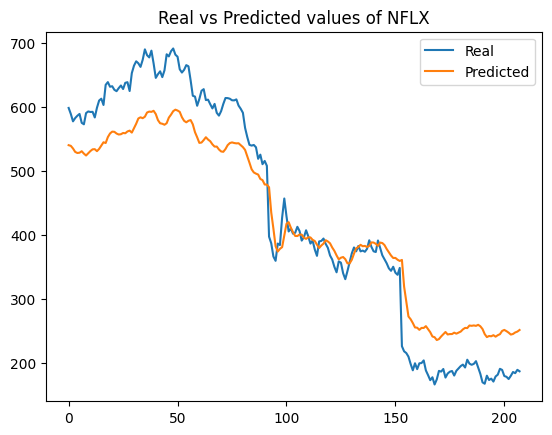

In [260]:
model_lstm_tf, pred_lstm_tf = regression_model(df_rfr_tf, X_rfr_tf, y_rfr_tf, "lstm", "tf", dates)

#### **Calculating Directional Accuracy of Predictions**

In [49]:
results_rfr = calculate_directional_accuracy(pred_rfr_tf)
results_xgbr = calculate_directional_accuracy(pred_xgbr_tf)
results_lstm = calculate_directional_accuracy(pred_lstm_tf)

# Save each DataFrame to the respective CSV file
results_rfr.to_csv("data/predictions/tf_pred_rfr.csv", index=False)
results_xgbr.to_csv("data/predictions/tf_pred_xgbr.csv", index=False)
results_lstm.to_csv("data/predictions/tf_pred_lstm.csv", index=False)

Percentage of correct directional predictions: 1.45%


### **Fundamental + Sentimental Features**

#### **Initial Data Analysis**

In [183]:
df_fs = pd.read_csv('data/F+S_regr.csv')
df_pred = df_fs[['Adj Close', 'EPS', 'pb_ratio', 'pe_ratio', 'roe', 'fcf', 'P_mean', 'P_sum', 'twt_count']]
print(df_fs)

            date   EPS  pb_ratio  pe_ratio    roe          fcf  P_mean  P_sum  \
0     2018-01-03  0.41     4.310   500.122  0.009 -509542000.0   0.071     24   
1     2018-01-04  0.41     4.323   500.122  0.009 -509542000.0  -0.018     -4   
2     2018-01-05  0.41     4.414   500.122  0.009 -509542000.0  -0.020     -6   
3     2018-01-08  0.41     4.458   500.122  0.009 -509542000.0  -0.008     -2   
4     2018-01-09  0.41     4.400   500.122  0.009 -509542000.0  -0.025     -6   
...          ...   ...       ...       ...    ...          ...     ...    ...   
1131  2022-07-01  3.20     3.676    54.647  0.067   12732000.0  -0.062    -21   
1132  2022-07-05  3.20     3.676    54.647  0.067   12732000.0  -0.059    -25   
1133  2022-07-06  3.20     3.676    54.647  0.067   12732000.0  -0.015     -8   
1134  2022-07-07  3.20     3.676    54.647  0.067   12732000.0  -0.055    -24   
1135  2022-07-08  3.20     3.676    54.647  0.067   12732000.0  -0.043    -12   

      twt_count  Adj Close 

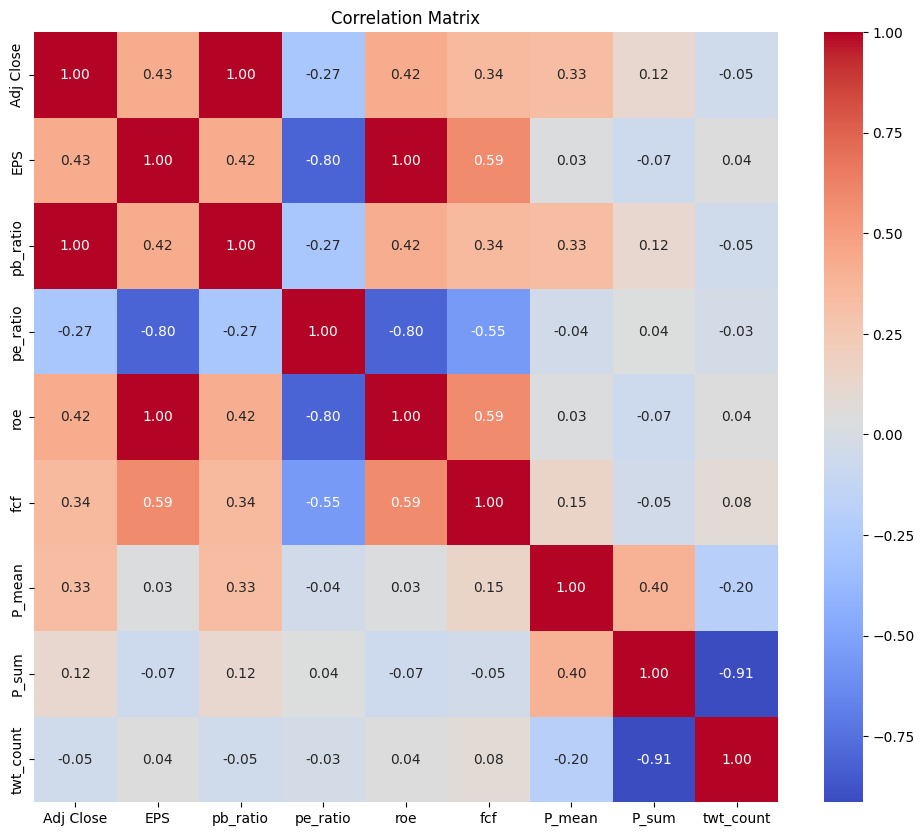

In [184]:
corr_matrix = df_pred.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [185]:
# Print the correlation values with the target variable
print("Correlation with Adj_Close:")
print(corr_matrix['Adj Close'].sort_values(ascending=False))

Correlation with Adj_Close:
Adj Close    1.000000
pb_ratio     0.999981
EPS          0.425671
roe          0.424812
fcf          0.343631
P_mean       0.332341
P_sum        0.123516
twt_count   -0.048438
pe_ratio    -0.274996
Name: Adj Close, dtype: float64


**Scatter Plot Correlating Tweet Count with Sentiment Scores:**

In [ ]:
df_ts_regr = pd.read_csv('data/T+S_regr.csv')

fig = px.scatter(df_ts_regr, x='twt_count', y='P_mean', title='Tweet Count vs Mean Sentiment Score',
                 labels={'twt_count': 'Tweet Count', 'P_mean': 'Mean Sentiment Score'})
fig.show()


#### **Hyperparameter Tuning - Feature Engineering**

**XG Boost Regressor** - To Select the best features we make use of XGBoost Regressor simply because rfr was unable to capture the patterns and relationships in the data and LSTM would require tuning the hyperparameters whilst finding the best features which is computationally super-heavy.

In [50]:
df_fs_regr = pd.read_csv('data/F+S_regr.csv')
best_score = float('-inf')
best_combination = None
window_size = 3

# Define lists of features
list1 = ['EPS', 'pb_ratio', 'pe_ratio', 'roe', 'fcf']
list2 = ['P_mean', 'P_sum', 'twt_count']

# Generate all combinations: one from list1 and one from list2
feature_combinations = list(itertools.product(list1, list2))

for comb in feature_combinations:
    selected_features = ['Adj Close'] + list(comb)
    df_pred_xgbr = df_fs_regr[['date'] + selected_features]
    df_pred_xgbr.set_index('date', inplace=True)

    X, y, dates = window_data(df_pred_xgbr, window_size, 0, 1, 2, 0) 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    model_xgbr, pred_xgbr = regression_model(df_pred_xgbr, X, y, "xgbr", "ts", dates)
    model_xgbr.fit(X_train, y_train)

    # Calculate CV RMSE and CV R2
    rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
    r2_scorer = make_scorer(r2_score)
    
    cv_rmse_scores = cross_val_score(model_xgbr, X, y.ravel(), cv=5, scoring=rmse_scorer)
    cv_r2_scores = cross_val_score(model_xgbr, X, y.ravel(), cv=5, scoring=r2_scorer)
    
    cv_rmse = -cv_rmse_scores.mean() 
    cv_r2 = cv_r2_scores.mean()
    
    score = cv_r2  - 0.1 * cv_rmse
    
    if score > best_score:
        best_score = score
        best_combination = selected_features
        
    print(f"Combination: {selected_features} with score: {score}")

print(f"Best combination of features: {best_combination} with score: {best_score} for XG Boost Regressor")


 XG Boost Regressor
Combination: ['Adj Close', 'EPS', 'P_mean'] with score: -1.603821269385643

 XG Boost Regressor
Combination: ['Adj Close', 'EPS', 'P_sum'] with score: -1.5746252383355328

 XG Boost Regressor
Combination: ['Adj Close', 'EPS', 'twt_count'] with score: -1.6322756086835013

 XG Boost Regressor
Combination: ['Adj Close', 'pb_ratio', 'P_mean'] with score: -1.3725250803231903

 XG Boost Regressor
Combination: ['Adj Close', 'pb_ratio', 'P_sum'] with score: -1.3374332005032945

 XG Boost Regressor
Combination: ['Adj Close', 'pb_ratio', 'twt_count'] with score: -1.415373302991511

 XG Boost Regressor
Combination: ['Adj Close', 'pe_ratio', 'P_mean'] with score: -1.5428159128610988

 XG Boost Regressor
Combination: ['Adj Close', 'pe_ratio', 'P_sum'] with score: -1.463873438932462

 XG Boost Regressor
Combination: ['Adj Close', 'pe_ratio', 'twt_count'] with score: -1.4762995040725975

 XG Boost Regressor
Combination: ['Adj Close', 'roe', 'P_mean'] with score: -1.62307322050333

**Hyperparameter Tuning - LSTM**

In [21]:
import pandas as pd
import altair as alt
import coloredlogs
from trading_bot.agent import Agent
from trading_bot.methods import evaluate_model, count_action
from trading_bot.utils import show_eval_result, switch_k_backend_device

# Load your data
df_fs = pd.read_csv('data/F+S_regr.csv')
df_fs = df_fs[['date', 'Adj Close', 'pb_ratio', 'P_mean']]
df_fs.set_index('date', inplace=True)

def main():
    coloredlogs.install(level='DEBUG')
    switch_k_backend_device()

    # model_name = 'models/fs_model_lstm.keras'
    test_stock = 'data/predictions/fs_pred_lstm1.csv'  # Dataset with real and predicted values
    debug = True

    # Load the dataset
    df = pd.read_csv(test_stock)

    # Initialize the agent with the pre-trained model
    agent = Agent(initial_capital=10000, max_trade_percent=0.1, buy_threshold=0.06, sell_threshold=-0.006)

    selling_profit, history, final_assets = evaluate_model(agent, df, debug)
    print("History:", history)
    print(f"Final assets: {final_assets}") # Total value of assets at end of trading session. Cash Balance + Stock Value of the stocks owned at the end of the session (stock price of last day). Went down from 10,000 to 7,413 because 38 shares were held onto
    print(f"Remaining Money: {agent.balance}")
    print("Selling Profit:", selling_profit) # Profit made from selling shares
    print(f"Total stocks owned: {len(agent.inventory)}")  # Print the total number of stocks owned

    # show_eval_result(model_name, profit, df['Real'][1] - df['Real'][0])
    count_action(history)


# param_grid = {
#     'units': [30, 50, 100, 150, 200],
#     'dropout': [0.2, 0.3, 0.4, 0.5],
#     'epochs': [100, 150, 200],
#     'window_sizes': [3, 4, 5],
#     'num_layers': [2, 3, 4],
#     'batch_sizes': [20, 24, 32] 
# }

param_grid = {
    'units': [30, 35, 40],
    'dropout': [0.2, 0.4],
    'epochs': [100, 150, 200],
    'window_sizes': [4,5],
    'num_layers': [2, 3, 4],
    'batch_sizes': [20, 24, 28] 
}

best_accuracy = 0
best_params = {}

for window_size in param_grid['window_sizes']:
    X_fs, y_fs, dates = window_data(df_fs, window_size, 0, 1, 2, 0)
    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X_fs, y_fs, dates, test_size=0.2, random_state=42, shuffle=False)
    X_train = X_train.reshape((X_train.shape[0], window_size, -1))
    X_test = X_test.reshape((X_test.shape[0], window_size, -1))
    X_train_scaled, y_train_scaled, scaler_X, scaler_y = scale_lstm_data(X_train, y_train)

    for units in param_grid['units']:
        for dropout in param_grid['dropout']:
            for epochs in param_grid['epochs']:
                for num_layers in param_grid['num_layers']:
                    for batch_size in param_grid['batch_sizes']:
                        print(f"Testing with parameters: units={units}, dropout={dropout}, epochs={epochs}, window_size={window_size}, num_layers={num_layers}, batch_size={batch_size}")
                        
                        model = build_lstm_model((X_train_scaled.shape[1], X_train_scaled.shape[2]), units, dropout, num_layers)
                        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
                        model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping], validation_split=0.1)

                        # Evaluate the model
                        X_test_scaled = scaler_X.transform(X_test.reshape(X_test.shape[0] * window_size, -1)).reshape(X_test.shape)
                        y_pred_scaled = model.predict(X_test_scaled)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled)

                        df_pred = pd.DataFrame({
                            'Date': dates_test,
                            'Real': y_test.flatten(),
                            'Predicted': y_pred.flatten()
                        })
                        
                        df_pred['Real_Change'] = df_pred['Real'].diff()
                        df_pred['Predicted_Change'] = df_pred['Predicted'].diff()
                        df_pred['Accuracy'] = ((df_pred['Real_Change'] > 0) & (df_pred['Predicted_Change'] > 0)) | ((df_pred['Real_Change'] < 0) & (df_pred['Predicted_Change'] < 0))
                        df_pred['Accuracy'] = df_pred['Accuracy'].astype(int)
                        df_pred.loc[df_pred.index[0], 'Accuracy'] = np.nan

                        accuracy = df_pred['Accuracy'].sum() / df_pred['Accuracy'].count() * 100
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_params = {'units': units, 'dropout': dropout, 'epochs': epochs, 'window_size': window_size, 'num_layers': num_layers, 'batch_size': batch_size}
                            
                            df_pred.drop(['Real_Change', 'Predicted_Change'], axis=1, inplace=True)
                            df_pred.rename(columns={'Date': 'date'}, inplace=True)
                            df_pred.to_csv('data/predictions/fs_pred_lstm1.csv', index=False)

                        print(f"Current Accuracy: {accuracy:.2f}%")

                print(f"Until Now: Best Parameters: {best_params}, Best Accuracy: {best_accuracy:.2f}%")

print(f"Final Best Parameters: {best_params}, Final Best Accuracy: {best_accuracy:.2f}%")

Testing with parameters: units=30, dropout=0.2, epochs=100, window_size=4, num_layers=2, batch_size=20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Current Accuracy: 55.31%
Testing with parameters: units=30, dropout=0.2, epochs=100, window_size=4, num_layers=2, batch_size=24
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Current Accuracy: 54.87%
Testing with parameters: units=30, dropout=0.2, epochs=100, window_size=4, num_layers=2, batch_size=28
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Current Accuracy: 55.75%
Testing with parameters: units=30, dropout=0.2, epochs=100, window_size=4, num_layers=3, batch_size=20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Current Accuracy: 54.42%
Testing with parameters: units=30, dropout=0.2, epochs=100, window_size=4, num_layers=3, batch_size=24
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Current Accuracy: 54.42%
Testing with parameters: units=30, dropout=0.2, epochs=100, window_size=4, num_layers=3, batch_size=28
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Current Accuracy: 55.75%
Test

In [20]:
import pandas as pd
import altair as alt
import coloredlogs
from trading_bot.agent import Agent
from trading_bot.methods import evaluate_model, count_action
from trading_bot.utils import show_eval_result, switch_k_backend_device

# Load your data
df_fs = pd.read_csv('data/F+S_regr.csv')
df_fs = df_fs[['date', 'Adj Close', 'pb_ratio', 'P_mean']]
df_fs.set_index('date', inplace=True)

param_grid = {
    'units': [30],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'epochs': [100, 150, 200, 250],
    'window_sizes': [4],
    'num_layers': [2],
    'batch_sizes': [20, 24, 28] 
}

# Until Now: Best Parameters: {'units': 30, 'dropout': 0.4, 'epochs': 200, 'window_size': 4, 'num_layers': 2, 'batch_size': 20}, Best Final Assets: 9943.61
# Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 200, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9893.429999999997
# Until Now: Best Parameters: {'units': 200, 'dropout': 0.2, 'epochs': 200, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9810.410000000003
# Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9796.009999999995

best_final_assets = 0
best_params = {}

for window_size in param_grid['window_sizes']:
    X_fs, y_fs, dates = window_data(df_fs, window_size, 0, 1, 2, 0)
    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X_fs, y_fs, dates, test_size=0.2, random_state=42, shuffle=False)
    X_train = X_train.reshape((X_train.shape[0], window_size, -1))
    X_test = X_test.reshape((X_test.shape[0], window_size, -1))
    X_train_scaled, y_train_scaled, scaler_X, scaler_y = scale_lstm_data(X_train, y_train)

    for units in param_grid['units']:
        for dropout in param_grid['dropout']:
            for epochs in param_grid['epochs']:
                for num_layers in param_grid['num_layers']:
                    for batch_size in param_grid['batch_sizes']:
                        print(f"Testing with parameters: units={units}, dropout={dropout}, epochs={epochs}, window_size={window_size}, num_layers={num_layers}, batch_size={batch_size}")
                        
                        model = build_lstm_model((X_train_scaled.shape[1], X_train_scaled.shape[2]), units, dropout, num_layers)
                        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
                        model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping], validation_split=0.1)

                        # Evaluate the model
                        X_test_scaled = scaler_X.transform(X_test.reshape(X_test.shape[0] * window_size, -1)).reshape(X_test.shape)
                        y_pred_scaled = model.predict(X_test_scaled)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled)

                        df_pred = pd.DataFrame({
                            'date': dates_test,
                            'Real': y_test.flatten(),
                            'Predicted': y_pred.flatten()
                        })
                        
                        # Run the trading simulation
                        agent = Agent(initial_capital=10000, max_trade_percent=0.1, buy_threshold=0.06, sell_threshold=-0.006)
                        _, final_assets = evaluate_model(agent, df_pred, debug=True)

                         # Check if the final assets are the highest
                        if final_assets > best_final_assets:
                            best_final_assets = final_assets
                            best_params = {'units': units, 'dropout': dropout, 'epochs': epochs, 'window_size': window_size, 'num_layers': num_layers, 'batch_size': batch_size}
                            df_pred.to_csv(f'data/predictions/fs_pred_lstm_best.csv', index=False)

                        print(f"Current Final Assets: {final_assets}")

                print(f"Until Now: Best Parameters: {best_params}, Best Final Assets: {best_final_assets}")

print(f"Final Best Parameters: {best_params}, Final Best Final Assets: {best_final_assets}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


227it [00:00, 6348.27it/s]             

Current Final Assets: 9616.159999999998
Testing with parameters: units=30, dropout=0.3, epochs=100, window_size=4, num_layers=2, batch_size=24


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


227it [00:00, 7266.38it/s]             

Current Final Assets: 9565.020000000002
Testing with parameters: units=30, dropout=0.3, epochs=100, window_size=4, num_layers=2, batch_size=28


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


227it [00:00, 6977.29it/s]             

Current Final Assets: 9536.760000000004
Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9859.109999999999
Testing with parameters: units=30, dropout=0.3, epochs=150, window_size=4, num_layers=2, batch_size=20


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


227it [00:00, 5965.47it/s]             

Current Final Assets: 9504.930000000008
Testing with parameters: units=30, dropout=0.3, epochs=150, window_size=4, num_layers=2, batch_size=24


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


227it [00:00, 6613.00it/s]             

Current Final Assets: 9621.750000000002
Testing with parameters: units=30, dropout=0.3, epochs=150, window_size=4, num_layers=2, batch_size=28


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


227it [00:00, 6847.33it/s]             

Current Final Assets: 9558.210000000006
Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9859.109999999999
Testing with parameters: units=30, dropout=0.3, epochs=200, window_size=4, num_layers=2, batch_size=20


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


227it [00:00, 6622.39it/s]             

Current Final Assets: 9602.480000000003
Testing with parameters: units=30, dropout=0.3, epochs=200, window_size=4, num_layers=2, batch_size=24


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


227it [00:00, 6672.37it/s]             

Current Final Assets: 9640.320000000005
Testing with parameters: units=30, dropout=0.3, epochs=200, window_size=4, num_layers=2, batch_size=28


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


227it [00:00, 5198.62it/s]             

Current Final Assets: 9760.460000000001
Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9859.109999999999
Testing with parameters: units=30, dropout=0.3, epochs=250, window_size=4, num_layers=2, batch_size=20


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


227it [00:00, 7545.80it/s]             

Current Final Assets: 9673.000000000002
Testing with parameters: units=30, dropout=0.3, epochs=250, window_size=4, num_layers=2, batch_size=24


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


227it [00:00, 4552.70it/s]             

Current Final Assets: 9547.620000000006
Testing with parameters: units=30, dropout=0.3, epochs=250, window_size=4, num_layers=2, batch_size=28


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


227it [00:00, 7174.88it/s]             

Current Final Assets: 9758.850000000008
Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9859.109999999999
Testing with parameters: units=30, dropout=0.4, epochs=100, window_size=4, num_layers=2, batch_size=20


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


227it [00:00, 6202.73it/s]             

Current Final Assets: 9491.420000000002
Testing with parameters: units=30, dropout=0.4, epochs=100, window_size=4, num_layers=2, batch_size=24


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


227it [00:00, 5048.45it/s]             

Current Final Assets: 9609.890000000003
Testing with parameters: units=30, dropout=0.4, epochs=100, window_size=4, num_layers=2, batch_size=28


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


227it [00:00, 6562.36it/s]             

Current Final Assets: 9651.660000000003
Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9859.109999999999
Testing with parameters: units=30, dropout=0.4, epochs=150, window_size=4, num_layers=2, batch_size=20


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


227it [00:00, 5080.02it/s]             

Current Final Assets: 9503.370000000004
Testing with parameters: units=30, dropout=0.4, epochs=150, window_size=4, num_layers=2, batch_size=24


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


227it [00:00, 4365.12it/s]             

Current Final Assets: 9701.45
Testing with parameters: units=30, dropout=0.4, epochs=150, window_size=4, num_layers=2, batch_size=28


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


227it [00:00, 5862.01it/s]             

Current Final Assets: 9602.680000000008
Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9859.109999999999
Testing with parameters: units=30, dropout=0.4, epochs=200, window_size=4, num_layers=2, batch_size=20


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


227it [00:00, 5688.57it/s]             

Current Final Assets: 9533.990000000007
Testing with parameters: units=30, dropout=0.4, epochs=200, window_size=4, num_layers=2, batch_size=24


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


227it [00:00, 5496.58it/s]             

Current Final Assets: 9672.720000000001
Testing with parameters: units=30, dropout=0.4, epochs=200, window_size=4, num_layers=2, batch_size=28


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


227it [00:00, 6743.25it/s]             

Current Final Assets: 9564.100000000004
Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9859.109999999999
Testing with parameters: units=30, dropout=0.4, epochs=250, window_size=4, num_layers=2, batch_size=20


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


227it [00:00, 5869.85it/s]             

Current Final Assets: 9665.769999999995
Testing with parameters: units=30, dropout=0.4, epochs=250, window_size=4, num_layers=2, batch_size=24


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


227it [00:00, 4278.36it/s]             

Current Final Assets: 9564.880000000003
Testing with parameters: units=30, dropout=0.4, epochs=250, window_size=4, num_layers=2, batch_size=28


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


227it [00:00, 5162.60it/s]             

Current Final Assets: 9634.009999999997
Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9859.109999999999
Testing with parameters: units=30, dropout=0.5, epochs=100, window_size=4, num_layers=2, batch_size=20


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


227it [00:00, 4981.52it/s]             

Current Final Assets: 9658.41
Testing with parameters: units=30, dropout=0.5, epochs=100, window_size=4, num_layers=2, batch_size=24


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


227it [00:00, 6484.55it/s]             

Current Final Assets: 9558.570000000007
Testing with parameters: units=30, dropout=0.5, epochs=100, window_size=4, num_layers=2, batch_size=28


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


227it [00:00, 6186.21it/s]             

Current Final Assets: 9693.429999999998
Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9859.109999999999
Testing with parameters: units=30, dropout=0.5, epochs=150, window_size=4, num_layers=2, batch_size=20


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


227it [00:00, 4977.35it/s]             

Current Final Assets: 9522.44
Testing with parameters: units=30, dropout=0.5, epochs=150, window_size=4, num_layers=2, batch_size=24


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


227it [00:00, 5144.13it/s]             

Current Final Assets: 9598.650000000003
Testing with parameters: units=30, dropout=0.5, epochs=150, window_size=4, num_layers=2, batch_size=28


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


227it [00:00, 4848.68it/s]             

Current Final Assets: 9523.730000000001
Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9859.109999999999
Testing with parameters: units=30, dropout=0.5, epochs=200, window_size=4, num_layers=2, batch_size=20


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


227it [00:00, 5375.61it/s]             

Current Final Assets: 9479.180000000002
Testing with parameters: units=30, dropout=0.5, epochs=200, window_size=4, num_layers=2, batch_size=24


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


227it [00:00, 5340.04it/s]             

Current Final Assets: 9757.220000000005
Testing with parameters: units=30, dropout=0.5, epochs=200, window_size=4, num_layers=2, batch_size=28


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


227it [00:00, 6357.17it/s]             

Current Final Assets: 9581.950000000008
Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9859.109999999999
Testing with parameters: units=30, dropout=0.5, epochs=250, window_size=4, num_layers=2, batch_size=20


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


227it [00:00, 5166.24it/s]             

Current Final Assets: 9692.509999999998
Testing with parameters: units=30, dropout=0.5, epochs=250, window_size=4, num_layers=2, batch_size=24


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


227it [00:00, 4183.12it/s]             

Current Final Assets: 9539.099999999997
Testing with parameters: units=30, dropout=0.5, epochs=250, window_size=4, num_layers=2, batch_size=28


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


227it [00:00, 5857.21it/s]             

Current Final Assets: 9606.150000000007
Until Now: Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Best Final Assets: 9859.109999999999
Final Best Parameters: {'units': 30, 'dropout': 0.2, 'epochs': 100, 'window_size': 4, 'num_layers': 2, 'batch_size': 24}, Final Best Final Assets: 9859.109999999999


#### **Executing the predictive models (after hyperparameter tuning) and obtaining their performance outcomes** 

In [46]:
df_fs = pd.read_csv('data/F+S_regr.csv')
df_fs = df_fs[['date', 'Adj Close', 'pb_ratio', 'P_mean']]
df_fs.set_index('date', inplace=True)

# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 4

# Column index 0 is the `Adj Close` column
# Column index 1 is the `ts_polarity` column
# Column index 2 is the `twitter_volume` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X_fs, y_fs, dates  = window_data(df_fs, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

**Random Forest Regressor**


 Random Forest Regressor
Root Mean Squared Error of rfr is:  90.6316104550105
R-squared of rfr is:  0.7376649911466678
Cross-Validation RMSE:  47.73036135865076
Cross-Validation R-squared:  0.24004663503202303
           date    Real   Predicted
0    2021-08-13  515.92  513.026321
1    2021-08-16  517.92  513.026321
2    2021-08-17  518.91  513.026321
3    2021-08-18  521.87  513.026321
4    2021-08-19  543.71  513.026321
..          ...     ...         ...
222  2022-07-01  179.95  288.292271
223  2022-07-05  185.88  288.292271
224  2022-07-06  184.06  288.292271
225  2022-07-07  189.27  288.292271
226  2022-07-08  186.98  288.292271

[227 rows x 3 columns]


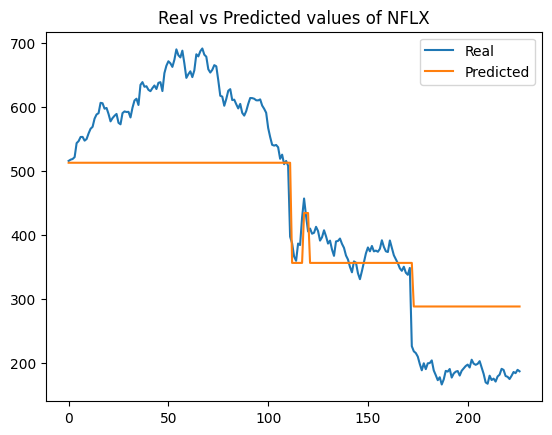

In [47]:
model_rfr_fs, pred_rfr_fs = regression_model(df_fs, X_fs, y_fs, "rfr", "fs", dates)

**XG Boost Regressor**


 XG Boost Regressor
Root Mean Squared Error of xgbr is:  60.24539315832118
R-squared of xgbr is:  0.8840836912441815
Cross-Validation RMSE:  22.299832757200143
Cross-Validation R-squared:  0.8574581953968238
           date    Real   Predicted
0    2021-08-13  515.92  510.694305
1    2021-08-16  517.92  502.712891
2    2021-08-17  518.91  517.841919
3    2021-08-18  521.87  509.710632
4    2021-08-19  543.71  525.708984
..          ...     ...         ...
222  2022-07-01  179.95  247.122467
223  2022-07-05  185.88  245.327164
224  2022-07-06  184.06  240.279266
225  2022-07-07  189.27  243.399536
226  2022-07-08  186.98  233.599701

[227 rows x 3 columns]


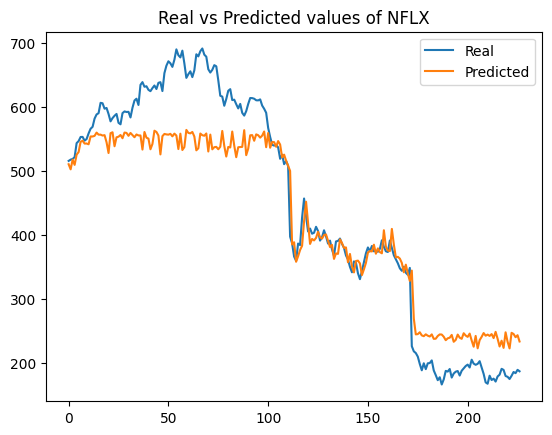

In [268]:
model_xgbr_fs, pred_xgbr_fs = regression_model(df_fs, X_fs, y_fs, "xgbr", "fs", dates)

**LSTM**


 LSTM_RNN


c:\Users\Devesh Pansare\miniconda3\envs\py312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


c:\Users\Devesh Pansare\miniconda3\envs\py312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


c:\Users\Devesh Pansare\miniconda3\envs\py312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


c:\Users\Devesh Pansare\miniconda3\envs\py312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


c:\Users\Devesh Pansare\miniconda3\envs\py312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Average CV RMSE for LSTM-RNN: 12.59324678075834
Average CV R-squared for LSTM-RNN: 0.9887052755083249
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Root Mean Squared Error of LSTM-RNN is: 64.58671873658312
R-squared of LSTM-RNN is: 0.8667757452214122
           date    Real   Predicted
0    2021-08-13  515.92  460.605225
1    2021-08-16  517.92  462.230164
2    2021-08-17  518.91  464.053925
3    2021-08-18  521.87  465.369232
4    2021-08-19  543.71  466.892517
..          ...     ...         ...
222  2022-07-01  179.95  229.769196
223  2022-07-05  185.88  231.251404
224  2022-07-06  184.06  234.282791
225  2022-07-07  189.27  235.162231
226  2022-07-08  186.98  237.223938

[227 rows x 3 columns]


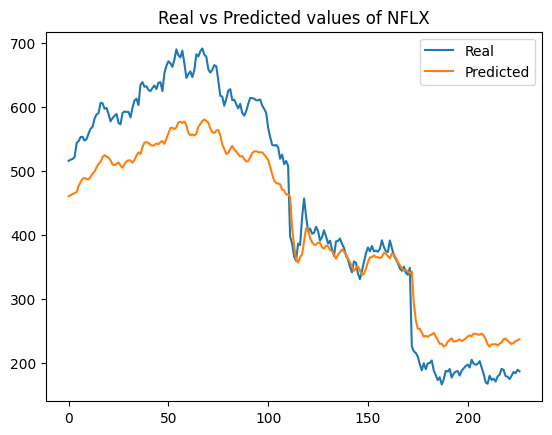

In [103]:
model_lstm_fs, pred_lstm_fs = regression_model(df_fs, X_fs, y_fs, "lstm", "fs", dates)

#### **Calculating Directional Accuracy of Predictions**

In [48]:
results_rfr = calculate_directional_accuracy(pred_rfr_fs)
results_xgbr = calculate_directional_accuracy(pred_xgbr_fs)
results_lstm = calculate_directional_accuracy(pred_lstm_fs)

# Save each DataFrame to the respective CSV file
results_rfr.to_csv("data/predictions/fs_pred_rfr.csv", index=False)
results_xgbr.to_csv("data/predictions/fs_pred_xgbr.csv", index=False)
results_lstm.to_csv("data/predictions/fs_pred_lstm.csv", index=False)

Percentage of correct directional predictions: 1.33%


### **Technical + Fundamental + Sentimental**

In [ ]:
df_pred = pd.read_csv('T+F+S_regr.csv')
print(df_pred)

In [ ]:
df_tfs = pd.read_csv('T+F+S_regr.csv')
print(df_tfs)
df_tfs = df_tfs[['Adj Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'EPS', 'pb_ratio', 'pe_ratio', 'roe', 'fcf', 'P_mean', 'P_sum', 'twt_count']]

corr_matrix = df_tfs.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

# Print the correlation values with the target variable
print("Correlation with Adj_Close:")
print(corr_matrix['Adj Close'].sort_values(ascending=False))


In [ ]:
from itertools import combinations

additional_features = ['Adj Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'EPS', 'pb_ratio', 'pe_ratio', 'roe', 'fcf', 'P_mean', 'P_sum', 'twt_count']

# Window size and target column number are constants in your case
window_size = 3
target_col_number = 1  # Assuming 'Adj Close' is always the target

# Iterate over all combinations of the additional features
for combination in combinations(additional_features, 2):
    # Prepare your DataFrame with the selected features plus 'date' and 'Adj Close'
    selected_features = ['date', 'Adj Close'] + list(combination)
    df_pred = df_tfs[selected_features]
    
    # Since 'date' and 'Adj Close' are fixed, the feature columns are 2 and 3 (0-based indexing after dropping 'date')
    feature_col_number1 = 1
    feature_col_number2 = 2
    feature_col_number3 = 3
    
    # Prepare the data using the window_data function
    X, y = window_data(df_pred, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

    print(f"Running lstm with features: {combination}")
    regression_model(df_pred, X, y, "lstm")

# **Classification Problem**

## **Technical + Sentimental**

In [7]:
df_ts_classi = pd.read_csv('data/T+S_classi.csv')
df_ts_classi = df_ts_classi[['Adj Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'P_mean', 'P_sum', 'twt_count', 'NFLX_Returns']]
print(df_ts_classi)

      Adj Close    Volume   SMA_20   SMA_50     RSI   MACD  Signal_Line  \
0        344.72  10049100  323.828  314.270  80.623  5.605        4.410   
1        349.29  14758600  325.594  314.825  79.142  6.789        4.886   
2        351.29   7817400  327.570  315.429  77.248  7.799        5.468   
3        349.73   9717900  329.434  316.054  74.370  8.376        6.050   
4        353.54   5685500  331.446  316.856  74.587  9.038        6.647   
...         ...       ...      ...      ...     ...    ...          ...   
1034     179.95   5194700  183.188  187.953  48.188 -5.970       -7.471   
1035     185.88   7334300  182.532  187.306  60.769 -5.120       -7.001   
1036     184.06   5753400  181.878  186.677  61.037 -4.541       -6.509   
1037     189.27   6334500  181.412  186.264  56.787 -3.619       -5.931   
1038     186.98   5831300  180.619  186.036  60.816 -3.039       -5.353   

      P_mean  P_sum  twt_count  NFLX_Returns  
0     0.0366     25        683             1  
1    

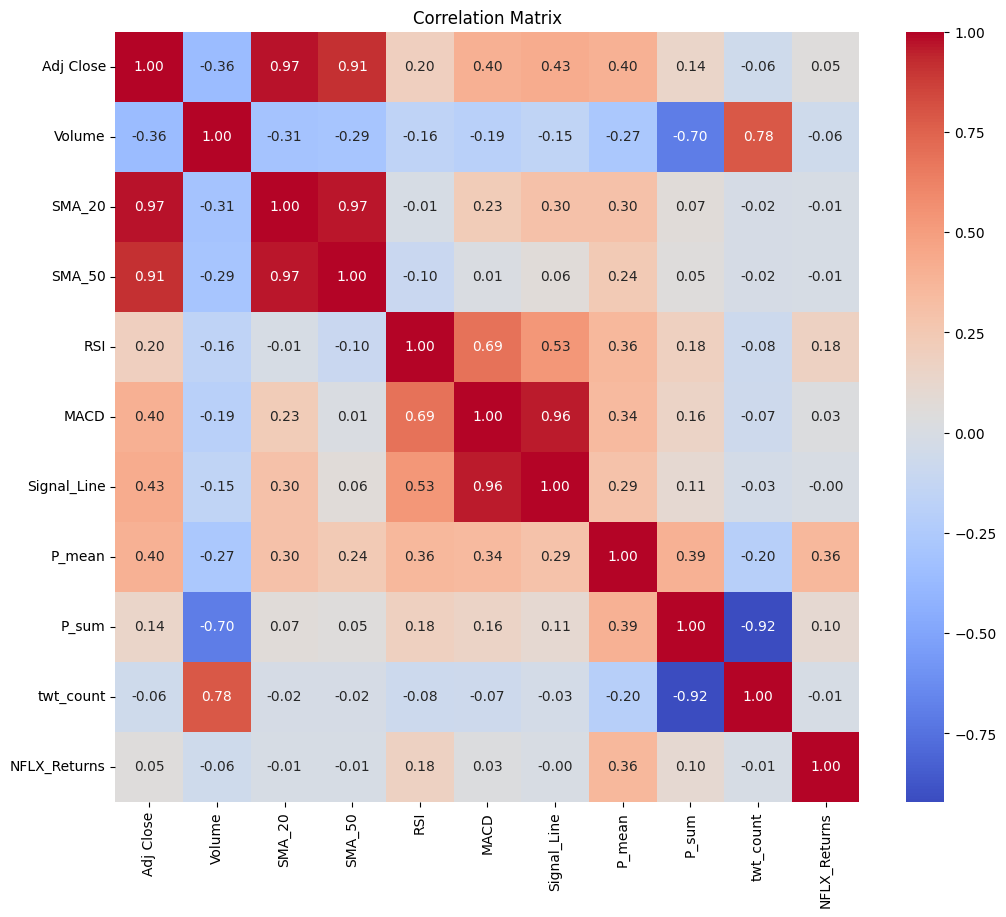

Correlation with NFLX_Returns:
NFLX_Returns    1.000000
P_mean          0.357973
RSI             0.175740
P_sum           0.100208
Adj Close       0.050489
MACD            0.026021
Signal_Line    -0.004333
SMA_20         -0.007009
SMA_50         -0.007720
twt_count      -0.010384
Volume         -0.058668
Name: NFLX_Returns, dtype: float64


In [8]:
corr_matrix = df_ts_classi.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

# Print the correlation values with the target variable
print("Correlation with NFLX_Returns:")
print(corr_matrix['NFLX_Returns'].sort_values(ascending=False))

In [9]:
df_ts_classi = df_ts_classi[['NFLX_Returns', 'SMA_20', 'P_sum']]
X = df_ts_classi.copy()
X.drop(columns=['NFLX_Returns'], inplace=True)
X.head()

y = df_ts_classi['NFLX_Returns'].values.reshape(-1, 1) 
y[:5]

array([[1],
       [1],
       [1],
       [0],
       [1]], dtype=int64)

In [13]:
classification_model(X, y, "rfc")
classification_model(X, y, "gbc")


 Random Forest Classifier
Accuracy score (training): 1.000
Mean cross-validation accuracy: 0.5619621342512908
Accuracy Score : 0.5625


,Predicted 0,Predicted 1
Actual 0,63,41
Actual 1,50,54


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.61      0.58       104
           1       0.57      0.52      0.54       104

    accuracy                           0.56       208
   macro avg       0.56      0.56      0.56       208
weighted avg       0.56      0.56      0.56       208


 Gradient Boosting Classifier
Accuracy score (training): 0.780
Mean cross-validation accuracy: 0.5740246701090074
Accuracy Score : 0.5480769230769231


,Predicted 0,Predicted 1
Actual 0,60,44
Actual 1,50,54


Classification Report
              precision    recall  f1-score   support

           0       0.55      0.58      0.56       104
           1       0.55      0.52      0.53       104

    accuracy                           0.55       208
   macro avg       0.55      0.55      0.55       208
weighted avg       0.55      0.55      0.55       208



## **Technical + Fundamental**

In [16]:
df_tf_classi = pd.read_csv('data/T+F_classi.csv')
df_tf_classi = df_tf_classi[['Adj Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'EPS', 'pe_ratio', 'pb_ratio', 'roe', 'fcf', 'NFLX_Returns']]
print(df_tf_classi)

      Adj Close    Volume   SMA_20   SMA_50     RSI   MACD  Signal_Line   EPS  \
0        344.72  10049100  323.828  314.270  80.623  5.605        4.410  0.64   
1        349.29  14758600  325.594  314.825  79.142  6.789        4.886  0.64   
2        351.29   7817400  327.570  315.429  77.248  7.799        5.468  0.64   
3        349.73   9717900  329.434  316.054  74.370  8.376        6.050  0.64   
4        353.54   5685500  331.446  316.856  74.587  9.038        6.647  0.64   
...         ...       ...      ...      ...     ...    ...          ...   ...   
1034     179.95   5194700  183.188  187.953  48.188 -5.970       -7.471  3.20   
1035     185.88   7334300  182.532  187.306  60.769 -5.120       -7.001  3.20   
1036     184.06   5753400  181.878  186.677  61.037 -4.541       -6.509  3.20   
1037     189.27   6334500  181.412  186.264  56.787 -3.619       -5.931  3.20   
1038     186.98   5831300  180.619  186.036  60.816 -3.039       -5.353  3.20   

      pe_ratio  pb_ratio   

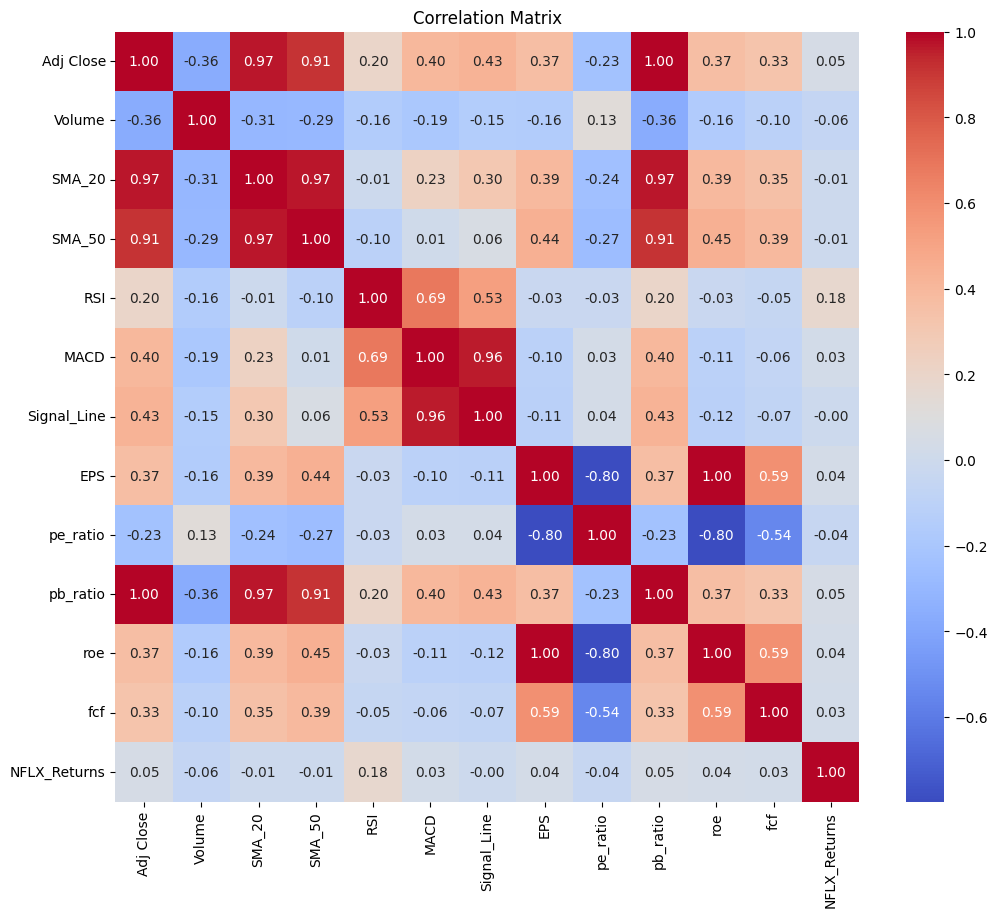

Correlation with NFLX_Returns:
NFLX_Returns    1.000000
RSI             0.175740
Adj Close       0.050489
pb_ratio        0.050378
EPS             0.036259
roe             0.036007
fcf             0.028743
MACD            0.026021
Signal_Line    -0.004333
SMA_20         -0.007009
SMA_50         -0.007720
pe_ratio       -0.039176
Volume         -0.058668
Name: NFLX_Returns, dtype: float64


In [17]:
corr_matrix = df_tf_classi.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

# Print the correlation values with the target variable
print("Correlation with NFLX_Returns:")
print(corr_matrix['NFLX_Returns'].sort_values(ascending=False))

In [18]:
df_tf_classi = df_tf_classi[['Adj Close', 'RSI', 'pb_ratio', 'NFLX_Returns']]
X = df_tf_classi.copy()
X.drop(columns=['NFLX_Returns'], inplace=True)
X.head()

y = df_tf_classi['NFLX_Returns'].values.reshape(-1, 1) 
y[:5]

array([[1],
       [1],
       [1],
       [0],
       [1]], dtype=int64)

In [19]:
classification_model(X, y, "rfc")
classification_model(X, y, "gbc")


 Random Forest Classifier
Accuracy score (training): 1.000
Mean cross-validation accuracy: 0.5390992541594952
Accuracy Score : 0.5576923076923077


,Predicted 0,Predicted 1
Actual 0,59,45
Actual 1,47,57


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.57      0.56       104
           1       0.56      0.55      0.55       104

    accuracy                           0.56       208
   macro avg       0.56      0.56      0.56       208
weighted avg       0.56      0.56      0.56       208


 Gradient Boosting Classifier
Accuracy score (training): 0.777
Mean cross-validation accuracy: 0.5463711990820425
Accuracy Score : 0.5288461538461539


,Predicted 0,Predicted 1
Actual 0,54,50
Actual 1,48,56


Classification Report
              precision    recall  f1-score   support

           0       0.53      0.52      0.52       104
           1       0.53      0.54      0.53       104

    accuracy                           0.53       208
   macro avg       0.53      0.53      0.53       208
weighted avg       0.53      0.53      0.53       208



## **Fundamental + Sentimental**

In [20]:
df_fs_classi = pd.read_csv('data/F+S_classi.csv')
print(df_fs_classi)

            date   EPS  pb_ratio  pe_ratio    roe          fcf  P_mean  P_sum  \
0     2018-05-23  0.64     7.247   461.484  0.013 -273927000.0   0.037     25   
1     2018-05-24  0.64     7.343   461.484  0.013 -273927000.0  -0.026    -22   
2     2018-05-25  0.64     7.385   461.484  0.013 -273927000.0  -0.026    -14   
3     2018-05-29  0.64     7.352   461.484  0.013 -273927000.0  -0.076    -30   
4     2018-05-30  0.64     7.432   461.484  0.013 -273927000.0  -0.108    -34   
...          ...   ...       ...       ...    ...          ...     ...    ...   
1034  2022-07-01  3.20     3.676    54.647  0.067   12732000.0  -0.062    -21   
1035  2022-07-05  3.20     3.676    54.647  0.067   12732000.0  -0.059    -25   
1036  2022-07-06  3.20     3.676    54.647  0.067   12732000.0  -0.015     -8   
1037  2022-07-07  3.20     3.676    54.647  0.067   12732000.0  -0.055    -24   
1038  2022-07-08  3.20     3.676    54.647  0.067   12732000.0  -0.043    -12   

      twt_count  NFLX_Retur

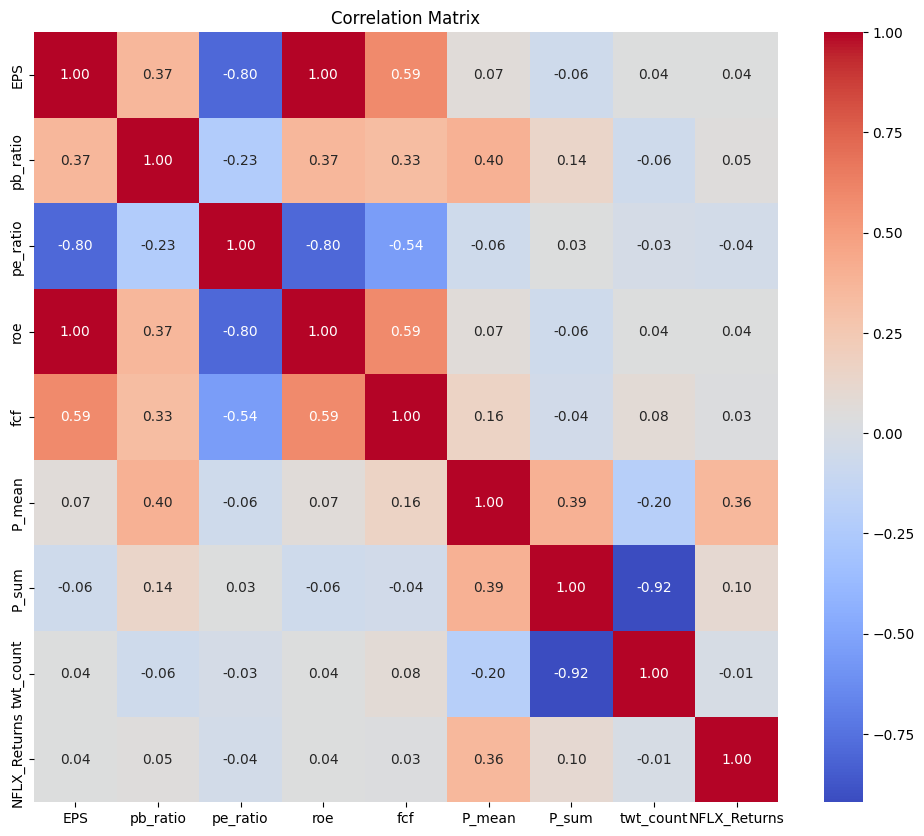

Correlation with NFLX_Returns:
NFLX_Returns    1.000000
P_mean          0.357925
P_sum           0.100208
pb_ratio        0.050378
EPS             0.036259
roe             0.036007
fcf             0.028743
twt_count      -0.010384
pe_ratio       -0.039176
Name: NFLX_Returns, dtype: float64


In [21]:
df_fs_classi = df_fs_classi[['EPS', 'pb_ratio', 'pe_ratio', 'roe', 'fcf', 'P_mean', 'P_sum', 'twt_count', 'NFLX_Returns']]
corr_matrix = df_fs_classi.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

# Print the correlation values with the target variable
print("Correlation with NFLX_Returns:")
print(corr_matrix['NFLX_Returns'].sort_values(ascending=False))

In [22]:
# df_fs_classi = df_fs_classi[['P_mean', 'pb_ratio', 'NFLX_Returns']]
X = df_fs_classi.copy()
X.drop(columns=['NFLX_Returns'], inplace=True)
X.head()

y = df_fs_classi['NFLX_Returns'].values.reshape(-1, 1) 
y[:5]

array([[1],
       [1],
       [1],
       [0],
       [1]], dtype=int64)

In [23]:
classification_model(X, y, "rfc")
classification_model(X, y, "gbc")


 Random Forest Classifier
Accuracy score (training): 1.000
Mean cross-validation accuracy: 0.610140562248996
Accuracy Score : 0.6442307692307693


,Predicted 0,Predicted 1
Actual 0,76,28
Actual 1,46,58


Classification Report
              precision    recall  f1-score   support

           0       0.62      0.73      0.67       104
           1       0.67      0.56      0.61       104

    accuracy                           0.64       208
   macro avg       0.65      0.64      0.64       208
weighted avg       0.65      0.64      0.64       208


 Gradient Boosting Classifier
Accuracy score (training): 0.832
Mean cross-validation accuracy: 0.6125071715433161
Accuracy Score : 0.6201923076923077


,Predicted 0,Predicted 1
Actual 0,69,35
Actual 1,44,60


Classification Report
              precision    recall  f1-score   support

           0       0.61      0.66      0.64       104
           1       0.63      0.58      0.60       104

    accuracy                           0.62       208
   macro avg       0.62      0.62      0.62       208
weighted avg       0.62      0.62      0.62       208



## **Technical + Fundamental + Sentimental**

In [24]:
df_tfs_classi = pd.read_csv('data/T+F+S_classi.csv')
print(df_tfs_classi)

            date  Adj Close    Volume   SMA_20   SMA_50     RSI   MACD  \
0     2018-05-23     344.72  10049100  323.828  314.270  80.623  5.605   
1     2018-05-24     349.29  14758600  325.594  314.825  79.142  6.789   
2     2018-05-25     351.29   7817400  327.570  315.429  77.248  7.799   
3     2018-05-29     349.73   9717900  329.434  316.054  74.370  8.376   
4     2018-05-30     353.54   5685500  331.446  316.856  74.587  9.038   
...          ...        ...       ...      ...      ...     ...    ...   
1034  2022-07-01     179.95   5194700  183.188  187.953  48.188 -5.970   
1035  2022-07-05     185.88   7334300  182.532  187.306  60.769 -5.120   
1036  2022-07-06     184.06   5753400  181.878  186.677  61.037 -4.541   
1037  2022-07-07     189.27   6334500  181.412  186.264  56.787 -3.619   
1038  2022-07-08     186.98   5831300  180.619  186.036  60.816 -3.039   

      Signal_Line   EPS  pb_ratio    pe_ratio       roe          fcf  P_mean  \
0           4.410  0.64  7.2465

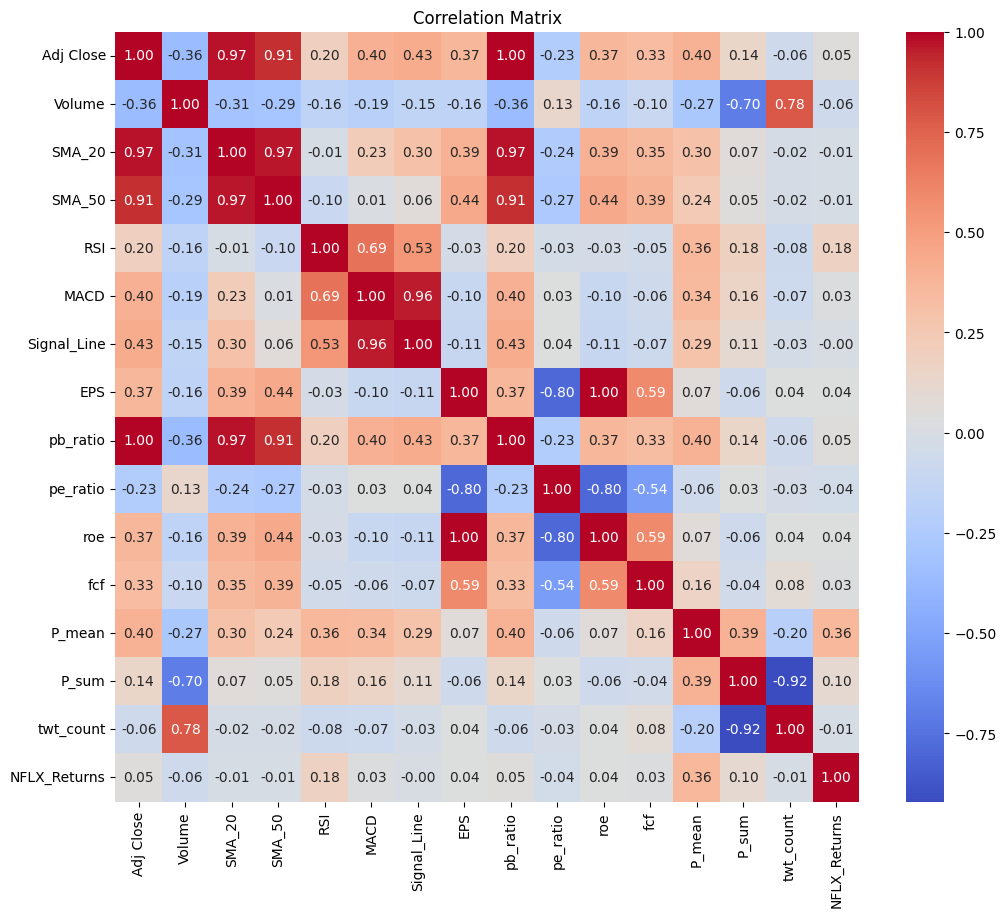

Correlation with NFLX_Returns:
NFLX_Returns    1.000000
P_mean          0.357973
RSI             0.175740
P_sum           0.100208
Adj Close       0.050489
pb_ratio        0.050372
EPS             0.036259
roe             0.036259
fcf             0.028743
MACD            0.026021
Signal_Line    -0.004333
SMA_20         -0.007009
SMA_50         -0.007720
twt_count      -0.010384
pe_ratio       -0.039176
Volume         -0.058668
Name: NFLX_Returns, dtype: float64


In [25]:
df_tfs_classi = df_tfs_classi[['Adj Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'EPS', 'pb_ratio', 'pe_ratio', 'roe', 'fcf', 'P_mean', 'P_sum', 'twt_count', 'NFLX_Returns']]
corr_matrix = df_tfs_classi.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

# Print the correlation values with the target variable
print("Correlation with NFLX_Returns:")
print(corr_matrix['NFLX_Returns'].sort_values(ascending=False))

In [26]:
# df_tfs_classi = df_tfs_classi[['P_mean', 'pb_ratio', 'NFLX_Returns']]
X = df_tfs_classi.copy()
X.drop(columns=['NFLX_Returns'], inplace=True)
X.head()

y = df_tfs_classi['NFLX_Returns'].values.reshape(-1, 1) 
y[:5]

array([[1],
       [1],
       [1],
       [0],
       [1]], dtype=int64)

In [27]:
classification_model(X, y, "rfc")
classification_model(X, y, "gbc")


 Random Forest Classifier
Accuracy score (training): 1.000
Mean cross-validation accuracy: 0.6281985083189903
Accuracy Score : 0.6586538461538461


,Predicted 0,Predicted 1
Actual 0,78,26
Actual 1,45,59


Classification Report
              precision    recall  f1-score   support

           0       0.63      0.75      0.69       104
           1       0.69      0.57      0.62       104

    accuracy                           0.66       208
   macro avg       0.66      0.66      0.66       208
weighted avg       0.66      0.66      0.66       208


 Gradient Boosting Classifier
Accuracy score (training): 0.865
Mean cross-validation accuracy: 0.6161216293746413
Accuracy Score : 0.6009615384615384


,Predicted 0,Predicted 1
Actual 0,70,34
Actual 1,49,55


Classification Report
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       104
           1       0.62      0.53      0.57       104

    accuracy                           0.60       208
   macro avg       0.60      0.60      0.60       208
weighted avg       0.60      0.60      0.60       208

